仿真初始化... 目标车辆: 3000
Time: 200s | Active: 103 | Done: 0
[ALERT] ID:42   Type:1 Time:313s Loc:7.20km
Time: 400s | Active: 224 | Done: 0
Time: 600s | Active: 321 | Done: 0
[ALERT] ID:19   Type:3 Time:623s Loc:12.53km
[ALERT] ID:26   Type:3 Time:639s Loc:19.33km
[ALERT] ID:119  Type:3 Time:735s Loc:17.58km
Time: 800s | Active: 426 | Done: 0
[ALERT] ID:305  Type:1 Time:813s Loc:6.52km
Time: 1000s | Active: 510 | Done: 0
[ALERT] ID:427  Type:2 Time:1007s Loc:4.90km
Time: 1200s | Active: 608 | Done: 1
Time: 1400s | Active: 705 | Done: 14
Time: 1600s | Active: 776 | Done: 44
[ALERT] ID:19   Type:3 Time:1645s Loc:36.15km
[ALERT] ID:595  Type:3 Time:1671s Loc:12.36km
[ALERT] ID:539  Type:3 Time:1729s Loc:16.38km
[ALERT] ID:686  Type:2 Time:1736s Loc:8.87km
Time: 1800s | Active: 811 | Done: 115
[ALERT] ID:800  Type:3 Time:1855s Loc:7.15km
Time: 2000s | Active: 818 | Done: 211
[ALERT] ID:839  Type:1 Time:2000s Loc:10.03km
[ALERT] ID:427  Type:2 Time:2017s Loc:29.43km
Time: 2200s | Active: 800 | Do

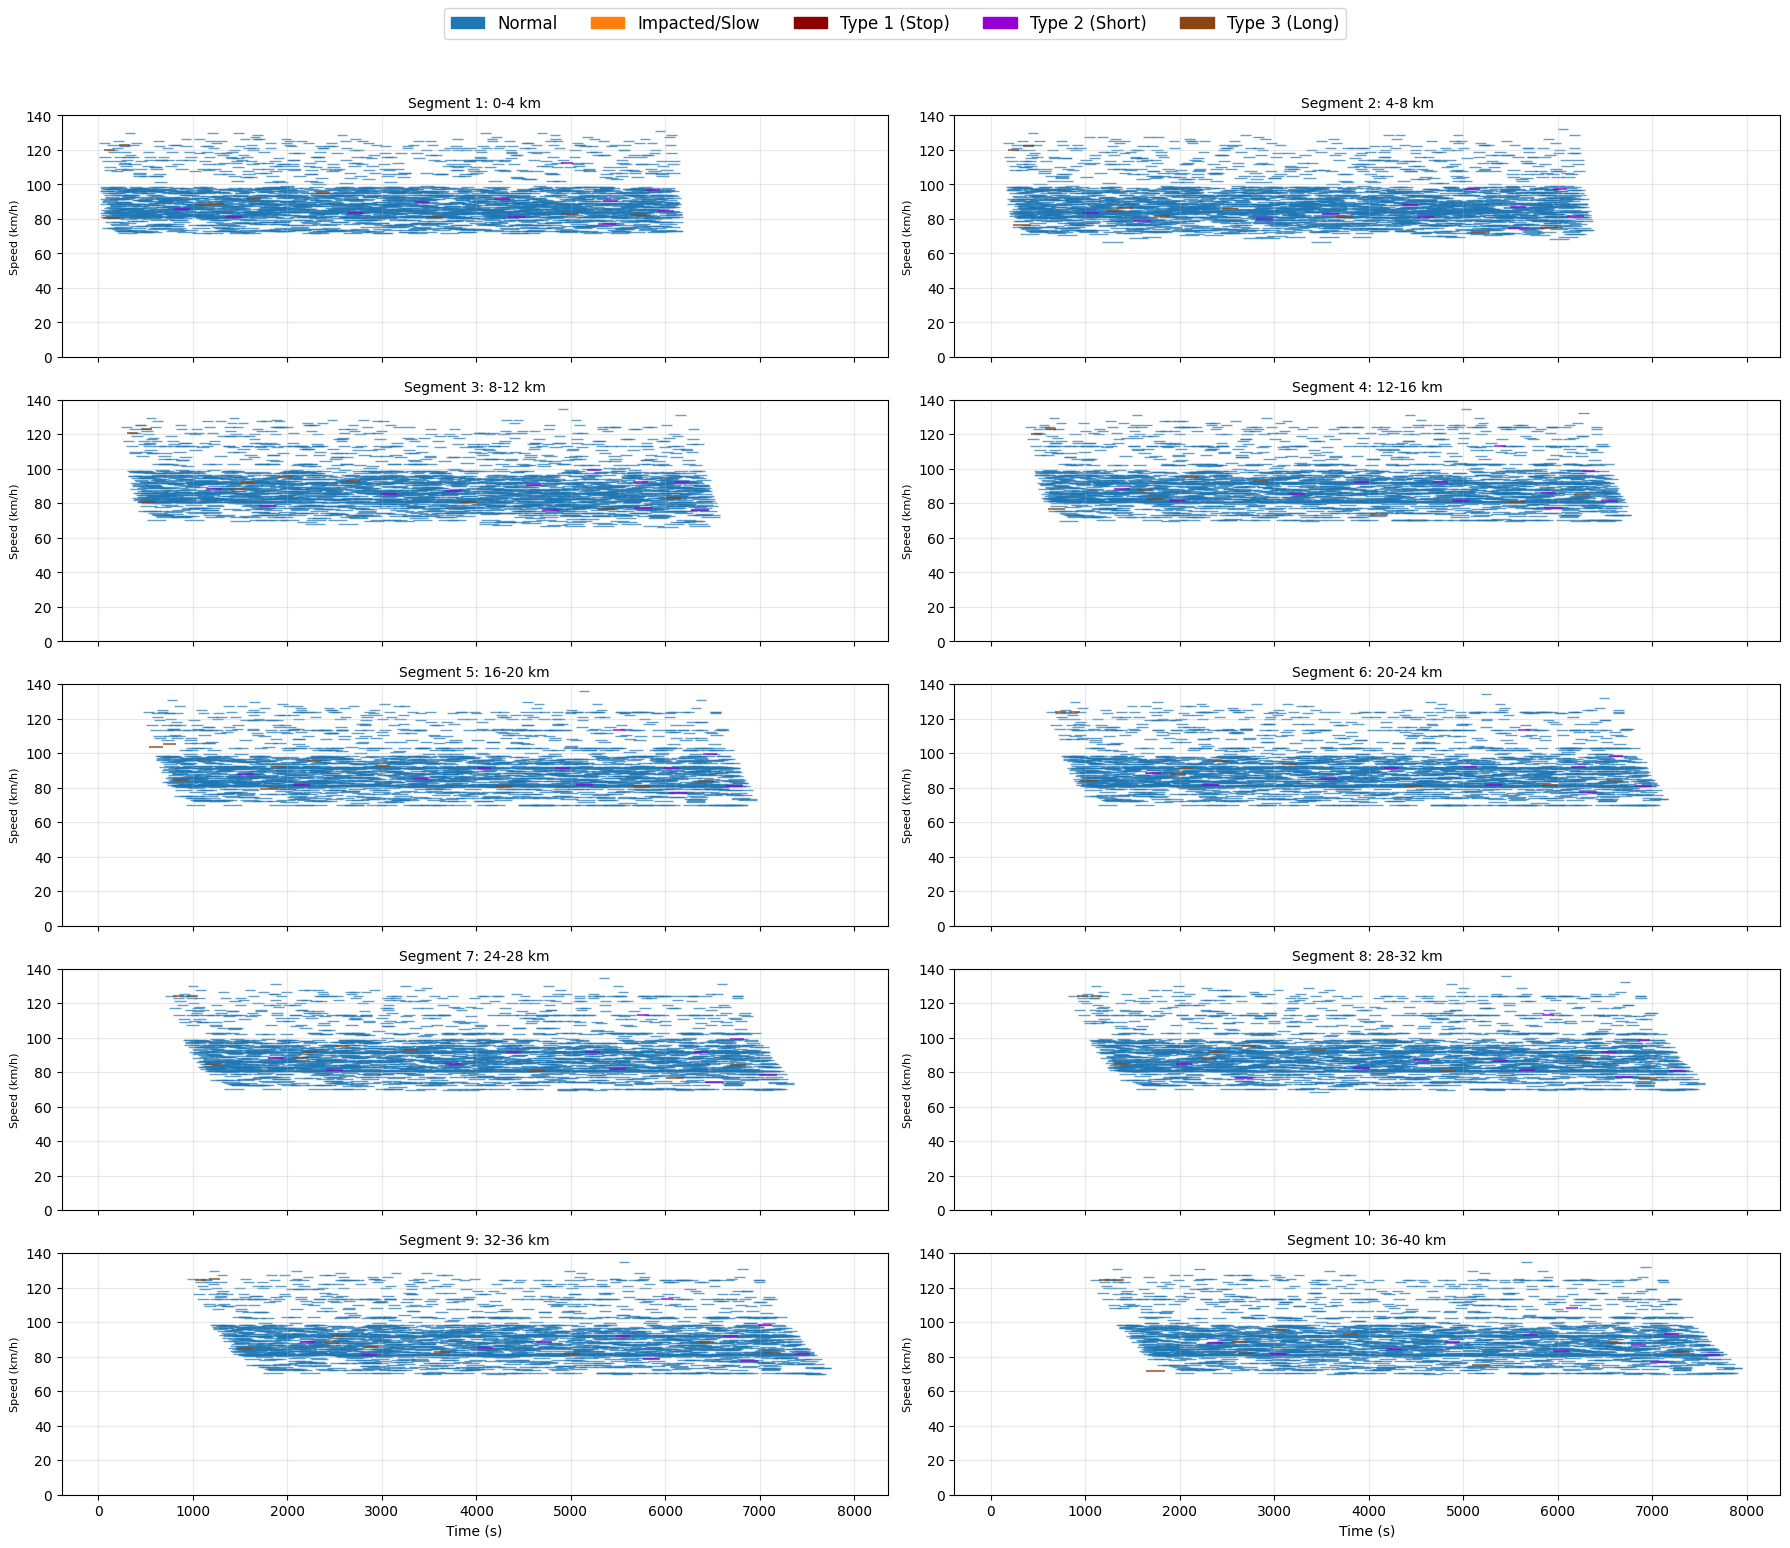

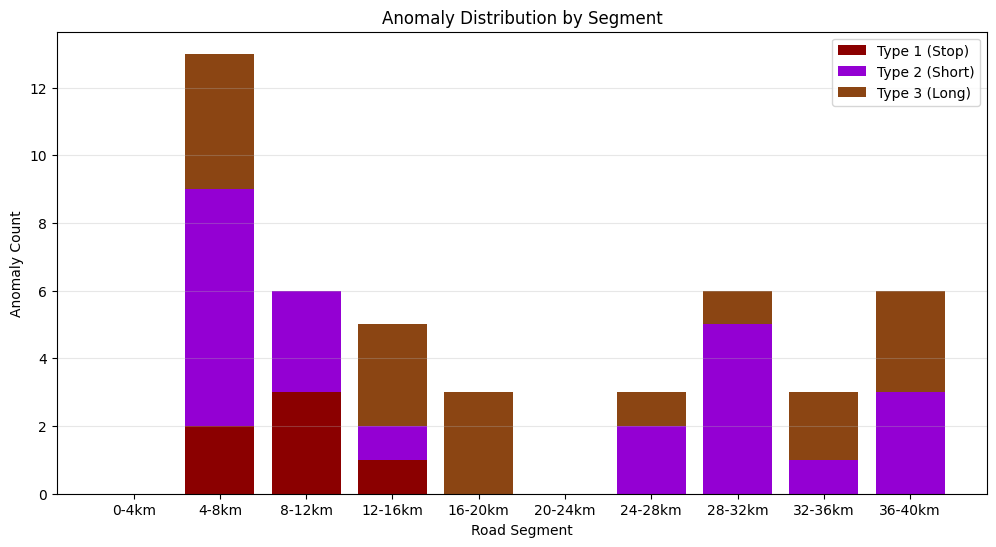


ID     | Type   | Trigger Time | Loc (km)   | State
----------------------------------------------------------------------
42     | 1      | 313.0        | 7.20       | Active
19     | 3      | 623.0        | 12.53      | Active
26     | 3      | 639.0        | 19.33      | Active
119    | 3      | 735.0        | 17.58      | Active
305    | 1      | 813.0        | 6.52       | Active
427    | 2      | 1007.0       | 4.90       | Active
19     | 3      | 1645.0       | 36.15      | Active
595    | 3      | 1671.0       | 12.36      | Active
539    | 3      | 1729.0       | 16.38      | Active
686    | 2      | 1736.0       | 8.87       | Active
800    | 3      | 1855.0       | 7.15       | Active
839    | 1      | 2000.0       | 10.03      | Active
427    | 2      | 2017.0       | 29.43      | Active
1164   | 3      | 2523.0       | 5.90       | Active
595    | 3      | 2691.0       | 37.95      | Active
686    | 2      | 2752.0       | 31.72      | Active
800    | 3      | 2877.0    

In [3]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

# --- 配置参数 (Configuration) ---
ROAD_LENGTH_KM = 40
SEGMENT_LENGTH_KM = 4
NUM_SEGMENTS = int(ROAD_LENGTH_KM / SEGMENT_LENGTH_KM)  # 10个区间
NUM_LANES = 4
TOTAL_VEHICLES_TARGET = 3000
SIMULATION_DT = 1.0  # 模拟步长 1秒

# 动力学参数 (m/s, m/s^2)
ACCEL_NORMAL = 3.0
DECEL_NORMAL = 3.0
DECEL_ANOMALY_TYPE1 = 7.0
DECEL_ANOMALY_TYPE23 = 4.0

# 速度设定 (km/h -> m/s)
def kmh_to_ms(v): return v / 3.6
def ms_to_kmh(v): return v * 3.6

SPEED_HIGH = (110, 120)
SPEED_NORMAL = (90, 90)
SPEED_LOW = (80, 80)

# 异常参数
ANOMALY_RATIO = 0.01        # 1% 的车是潜在异常车
GLOBAL_ANOMALY_START = 200  # 全局仿真时间必须 > 200s
VEHICLE_SAFE_RUN_TIME = 200 # 车辆自身必须正常跑满 200s
ANOMALY_IMPACT_DIST = 250   # 米 (后方影响范围)
TYPE1_BLOCK_DIST = 100      # 米 (前后封锁范围)

# 颜色定义
COLOR_NORMAL = '#1f77b4'  # Blue
COLOR_IMPACTED = '#ff7f0e' # Orange
COLOR_TYPE1 = '#8b0000'    # Dark Red (完全静止)
COLOR_TYPE2 = '#9400d3'    # Purple (短暂)
COLOR_TYPE3 = '#8b4513'    # Saddle Brown (长时)

# --- 车辆类 (Vehicle Class) ---
class Vehicle:
    def __init__(self, v_id, entry_time, lane):
        self.id = v_id
        self.lane = lane # 0, 1, 2, 3
        self.pos = 0.0   # meters
        
        # 速度初始化
        r = random.random()
        if r < 0.15: # 高速
            base_speed = random.uniform(*SPEED_HIGH)
        elif r < 0.75: # 正常
            base_speed = random.uniform(*SPEED_NORMAL)
        else: # 低速
            base_speed = random.uniform(*SPEED_LOW)
        
        # 初始速度波动 +/- 10%
        self.desired_speed = kmh_to_ms(base_speed * random.uniform(0.9, 1.1))
        self.speed = self.desired_speed
        
        # 异常属性
        self.is_potential_anomaly = (random.random() < ANOMALY_RATIO)
        self.anomaly_type = 0 # 0:None, 1:Stop, 2:Short, 3:Long
        self.anomaly_state = 'normal' # normal, active, cooling
        self.anomaly_timer = 0
        self.cooldown_timer = 0
        self.color = COLOR_NORMAL
        
        # 记录数据
        self.logs = {} 
        self.current_segment = 0
        self.entry_time = entry_time
        self.finished = False
        
        self.lane_change_cooldown = 0

    def trigger_anomaly(self, current_time, segment_idx):
        """尝试触发异常状态机 (修复后的逻辑)"""
        # 1. 基础资格检查
        if not self.is_potential_anomaly: return None
        if self.anomaly_state == 'active': return None
        
        # 2. 冷却期检查
        if self.anomaly_state == 'cooling':
            self.cooldown_timer -= 1
            if self.cooldown_timer <= 0:
                self.anomaly_state = 'normal' # 冷却结束，允许复发
            else:
                return None # 还在冷却中

        # 3. 时间门槛检查 (核心修复点)
        # 全局时间必须 > 200s
        if current_time < GLOBAL_ANOMALY_START: return None
        # 车辆自身必须正常运行了 200s (避免刚进场就坏)
        if (current_time - self.entry_time) < VEHICLE_SAFE_RUN_TIME: return None

        # 4. 触发判定
        trigger = False
        
        # 情况A: 第一次触发
        if self.anomaly_type == 0:
            # 这里的概率控制着"满足条件后多久触发"。
            # 0.005/s 意味着平均 200秒内会触发。防止所有满足条件的车同一秒爆炸。
            if random.random() < 0.005: 
                trigger = True
                # 随机决定异常类型
                r = random.random()
                if r < 0.33: self.anomaly_type = 1
                elif r < 0.66: self.anomaly_type = 2
                else: self.anomaly_type = 3
                
        # 情况B: 复发 (Type 2/3)
        elif self.anomaly_type in [2, 3]: 
            # 冷却结束后，每秒 30% 概率复发
            if random.random() < 0.3: 
                trigger = True
        
        # 5. 执行触发
        if trigger:
            self.anomaly_state = 'active'
            
            if self.anomaly_type == 1:
                self.target_speed_override = 0
                self.color = COLOR_TYPE1
                self.anomaly_timer = 999999 # 永久
            elif self.anomaly_type == 2:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 10 # 持续10s
                self.color = COLOR_TYPE2
            elif self.anomaly_type == 3:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 20 # 持续20s
                self.color = COLOR_TYPE3
            
            return {
                'id': self.id,
                'type': self.anomaly_type,
                'time': current_time,
                'pos_km': self.pos / 1000.0,
                'segment': segment_idx,
                'min_speed': ms_to_kmh(self.target_speed_override)
            }
        return None

    def update(self, dt, vehicles_nearby, blocked_lanes):
        """更新车辆物理状态"""
        if self.finished: return

        # --- 状态机倒计时 ---
        target_v = self.desired_speed
        max_decel = DECEL_NORMAL
        
        if self.anomaly_state == 'active':
            target_v = self.target_speed_override
            if self.anomaly_type == 1: max_decel = DECEL_ANOMALY_TYPE1
            else: max_decel = DECEL_ANOMALY_TYPE23
            
            self.anomaly_timer -= dt
            # 异常结束恢复
            if self.anomaly_timer <= 0 and self.anomaly_type != 1:
                self.anomaly_state = 'cooling'
                self.cooldown_timer = 1000 # 冷却1000s
                self.color = COLOR_NORMAL
        
        # --- 交互逻辑 (前车判定) ---
        leader = None
        min_dist = 99999
        
        for other in vehicles_nearby:
            if other.lane == self.lane and other.pos > self.pos:
                dist = other.pos - self.pos
                if dist < min_dist:
                    min_dist = dist
                    leader = other
        
        # --- 异常影响 & Type 1 封锁 ---
        impacted_by_anomaly = False
        if leader:
            # Type 1 封锁
            if leader.anomaly_type == 1 and min_dist < TYPE1_BLOCK_DIST + 50:
                target_v = 0
                max_decel = DECEL_ANOMALY_TYPE1
            # Type 2/3 影响
            elif leader.anomaly_state == 'active' and min_dist < ANOMALY_IMPACT_DIST:
                target_v = min(target_v, leader.speed * 0.8)
                impacted_by_anomaly = True
        
        # --- 换道逻辑 ---
        self.lane_change_cooldown -= dt
        want_change = False
        
        if leader:
            safe_following_dist = self.speed * 2 + 15
            # 前方有Type1 或 距离过近触发换道
            if (min_dist < safe_following_dist) or (leader.anomaly_type == 1 and min_dist < 200):
                want_change = True
        
        if want_change and self.lane_change_cooldown <= 0:
            options = []
            if self.lane > 0: options.append(self.lane - 1)
            if self.lane < NUM_LANES - 1: options.append(self.lane + 1)
            
            random.shuffle(options)
            for target_lane in options:
                safe = True
                # 检查Type 1 封锁
                if target_lane in blocked_lanes:
                    for block_pos in blocked_lanes[target_lane]:
                        if abs(block_pos - self.pos) < TYPE1_BLOCK_DIST:
                            safe = False; break
                if not safe: continue

                # 检查目标车道空隙
                for other in vehicles_nearby:
                    if other.lane == target_lane:
                        if abs(other.pos - self.pos) < 35: # 间距
                            safe = False; break
                
                if safe:
                    self.lane = target_lane
                    self.lane_change_cooldown = 5.0
                    break

        # --- 颜色更新 ---
        if self.anomaly_state != 'active':
            if impacted_by_anomaly or (leader and min_dist < 40 and self.speed < 20):
                self.color = COLOR_IMPACTED
            else:
                self.color = COLOR_NORMAL

        # --- 物理积分 ---
        if self.speed < target_v:
            self.speed += ACCEL_NORMAL * dt
        elif self.speed > target_v:
            self.speed -= max_decel * dt
        if self.speed < 0: self.speed = 0
        
        self.pos += self.speed * dt
        
        # --- 数据记录 ---
        # 注意：这里不应该更新记录，应该在 record_time 中统一处理
        # seg_idx 的计算移到 record_time 调用之前
            
    def record_time(self, time_now, seg_idx):
        """记录车辆在各区间的时间"""
        if seg_idx >= NUM_SEGMENTS: 
            self.finished = True
            # 离开最后一个区间时，更新最后区间的 out 时间
            if self.current_segment < NUM_SEGMENTS and self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            return
        
        # 如果进入了新区间
        if seg_idx != self.current_segment:
            # 更新旧区间的离开时间
            if self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            
            # 记录新区间的进入时间
            self.current_segment = seg_idx
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
        else:
            # 在当前区间内，持续更新 out 时间
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
            else:
                self.logs[seg_idx]['out'] = time_now

# --- 仿真主程序 ---
class TrafficSimulation:
    def __init__(self):
        self.vehicles = []
        self.finished_vehicles = []
        self.current_time = 0
        self.vehicle_id_counter = 0
        self.anomaly_logs = []
        self.spawn_schedule = []
        self.plan_spawns()
        
    def plan_spawns(self):
        """生成随机投放计划：每10s随机2-8辆"""
        total_generated = 0
        t_cycle = 0
        while total_generated < TOTAL_VEHICLES_TARGET:
            n = random.randint(2, 8) # 随机数量
            if total_generated + n > TOTAL_VEHICLES_TARGET:
                n = TOTAL_VEHICLES_TARGET - total_generated
            
            # 在这10s内随机时间点
            timestamps = sorted([t_cycle + random.uniform(0, 10) for _ in range(n)])
            for ts in timestamps:
                self.spawn_schedule.append(ts)
            
            total_generated += n
            t_cycle += 10
            
    def run(self):
        print("仿真初始化... 目标车辆: 3000")
        spawn_idx = 0
        
        while len(self.vehicles) > 0 or spawn_idx < len(self.spawn_schedule):
            # 1. 车辆投放 (带空间冲突检测)
            while spawn_idx < len(self.spawn_schedule) and self.spawn_schedule[spawn_idx] <= self.current_time:
                lane_choice = list(range(NUM_LANES))
                random.shuffle(lane_choice)
                placed = False
                
                for lane in lane_choice:
                    clear = True
                    # 检查入口50米是否有车
                    for v in self.vehicles:
                        if v.lane == lane and v.pos < 50:
                            clear = False; break
                    if clear:
                        new_v = Vehicle(self.vehicle_id_counter, self.current_time, lane)
                        self.vehicles.append(new_v)
                        self.vehicle_id_counter += 1
                        placed = True
                        break
                
                if placed:
                    spawn_idx += 1
                else:
                    # 如果堵死，推迟到下一秒
                    self.spawn_schedule[spawn_idx] += 1.0
                    break 

            # 2. 空间索引
            active_vehicles = [v for v in self.vehicles if not v.finished]
            active_vehicles.sort(key=lambda x: x.pos)
            
            blocked_lanes = defaultdict(list)
            for v in active_vehicles:
                if v.anomaly_type == 1 and v.anomaly_state == 'active':
                    blocked_lanes[v.lane].append(v.pos)

            # 3. 更新
            for v in active_vehicles:
                seg = int(v.pos / (SEGMENT_LENGTH_KM * 1000))
                v.record_time(self.current_time, seg)
                
                # 异常检测
                log = v.trigger_anomaly(self.current_time, seg)
                if log:
                    self.anomaly_logs.append(log)
                    print(f"[ALERT] ID:{log['id']:<4} Type:{log['type']} Time:{log['time']:.0f}s Loc:{log['pos_km']:.2f}km")

                v.update(SIMULATION_DT, active_vehicles, blocked_lanes)

            # 4. 清理
            completed = [v for v in self.vehicles if v.finished]
            self.finished_vehicles.extend(completed)
            self.vehicles = [v for v in self.vehicles if not v.finished]
            
            self.current_time += SIMULATION_DT
            
            if int(self.current_time) % 200 == 0:
                print(f"Time: {int(self.current_time)}s | Active: {len(self.vehicles)} | Done: {len(self.finished_vehicles)}")
                # 超时保护 (比如3小时)
                if self.current_time > 10800: break

        print("仿真完成。")

# --- 可视化模块 ---
def plot_results(finished_vehicles, anomaly_logs):
    print("正在渲染图表 (可能需要几秒钟)...")
    print(f"完成车辆数: {len(finished_vehicles)}")
    print(f"异常事件数: {len(anomaly_logs)}")
    
    # 统计有记录的车辆数
    vehicles_with_logs = sum(1 for v in finished_vehicles if len(v.logs) > 0)
    print(f"有区间记录的车辆数: {vehicles_with_logs}")
    
    # 统计每个区间的记录数
    segment_counts = [0] * NUM_SEGMENTS
    for v in finished_vehicles:
        for seg_idx in v.logs:
            if seg_idx < NUM_SEGMENTS:
                segment_counts[seg_idx] += 1
    print(f"各区间记录数: {segment_counts}")
    
    # 1. 速度画像 (10个子图)
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                # 确保时间差有效（至少0.1秒）
                if t_out - t_in < 0.1: 
                    continue
                
                # 计算平均速度 (km/h)
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                # 限制速度范围（避免异常值）
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                # 颜色逻辑
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5 # 拥堵
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    # 图例
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 2. 异常统计堆叠柱状图
    plt.figure(figsize=(12, 6))
    counts = {seg: {1:0, 2:0, 3:0} for seg in range(NUM_SEGMENTS)}
    for log in anomaly_logs:
        seg = log['segment']
        if seg < NUM_SEGMENTS:
            counts[seg][log['type']] += 1
            
    x_labels = [f"{i*4}-{(i+1)*4}km" for i in range(NUM_SEGMENTS)]
    y1 = [counts[i][1] for i in range(NUM_SEGMENTS)]
    y2 = [counts[i][2] for i in range(NUM_SEGMENTS)]
    y3 = [counts[i][3] for i in range(NUM_SEGMENTS)]
    
    x = range(len(x_labels))
    plt.bar(x, y1, color=COLOR_TYPE1, label='Type 1 (Stop)')
    plt.bar(x, y2, bottom=y1, color=COLOR_TYPE2, label='Type 2 (Short)')
    plt.bar(x, y3, bottom=[sum(x) for x in zip(y1, y2)], color=COLOR_TYPE3, label='Type 3 (Long)')
    
    plt.xlabel('Road Segment')
    plt.ylabel('Anomaly Count')
    plt.title('Anomaly Distribution by Segment')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 3. 终端打印
    print("\n" + "="*70)
    print(f"{'ID':<6} | {'Type':<6} | {'Trigger Time':<12} | {'Loc (km)':<10} | {'State'}")
    print("-" * 70)
    for log in anomaly_logs:
        print(f"{log['id']:<6} | {log['type']:<6} | {log['time']:<12.1f} | {log['pos_km']:<10.2f} | Active")
    print("="*70)

if __name__ == "__main__":
    sim = TrafficSimulation()
    sim.run()
    plot_results(sim.finished_vehicles, sim.anomaly_logs)

仿真初始化... 目标车辆: 3000
Time: 200s | Active: 95 | Done: 0
[ALERT] ID:0    Type:3 Time:302s Loc:6.77km
[ALERT] ID:36   Type:3 Time:383s Loc:8.50km
Time: 400s | Active: 193 | Done: 0
Time: 600s | Active: 283 | Done: 0
[ALERT] ID:205  Type:1 Time:678s Loc:5.80km
[ALERT] ID:170  Type:1 Time:740s Loc:8.96km
[ALERT] ID:275  Type:2 Time:799s Loc:5.23km
Time: 800s | Active: 383 | Done: 0
Time: 1000s | Active: 486 | Done: 0
[ALERT] ID:467  Type:3 Time:1177s Loc:4.31km
Time: 1200s | Active: 590 | Done: 1
[ALERT] ID:0    Type:3 Time:1323s Loc:28.90km
[ALERT] ID:555  Type:1 Time:1377s Loc:5.52km
Time: 1400s | Active: 685 | Done: 11
[ALERT] ID:36   Type:3 Time:1402s Loc:35.99km
Time: 1600s | Active: 766 | Done: 39
Time: 1800s | Active: 802 | Done: 96
[ALERT] ID:275  Type:2 Time:1808s Loc:27.60km
[ALERT] ID:740  Type:1 Time:1961s Loc:14.17km
Time: 2000s | Active: 803 | Done: 175
正在保存 2000s 时刻快照...
已保存: output\traffic_snapshot_2000s.png
[ALERT] ID:897  Type:1 Time:2106s Loc:7.90km
[ALERT] ID:467  Type:3 

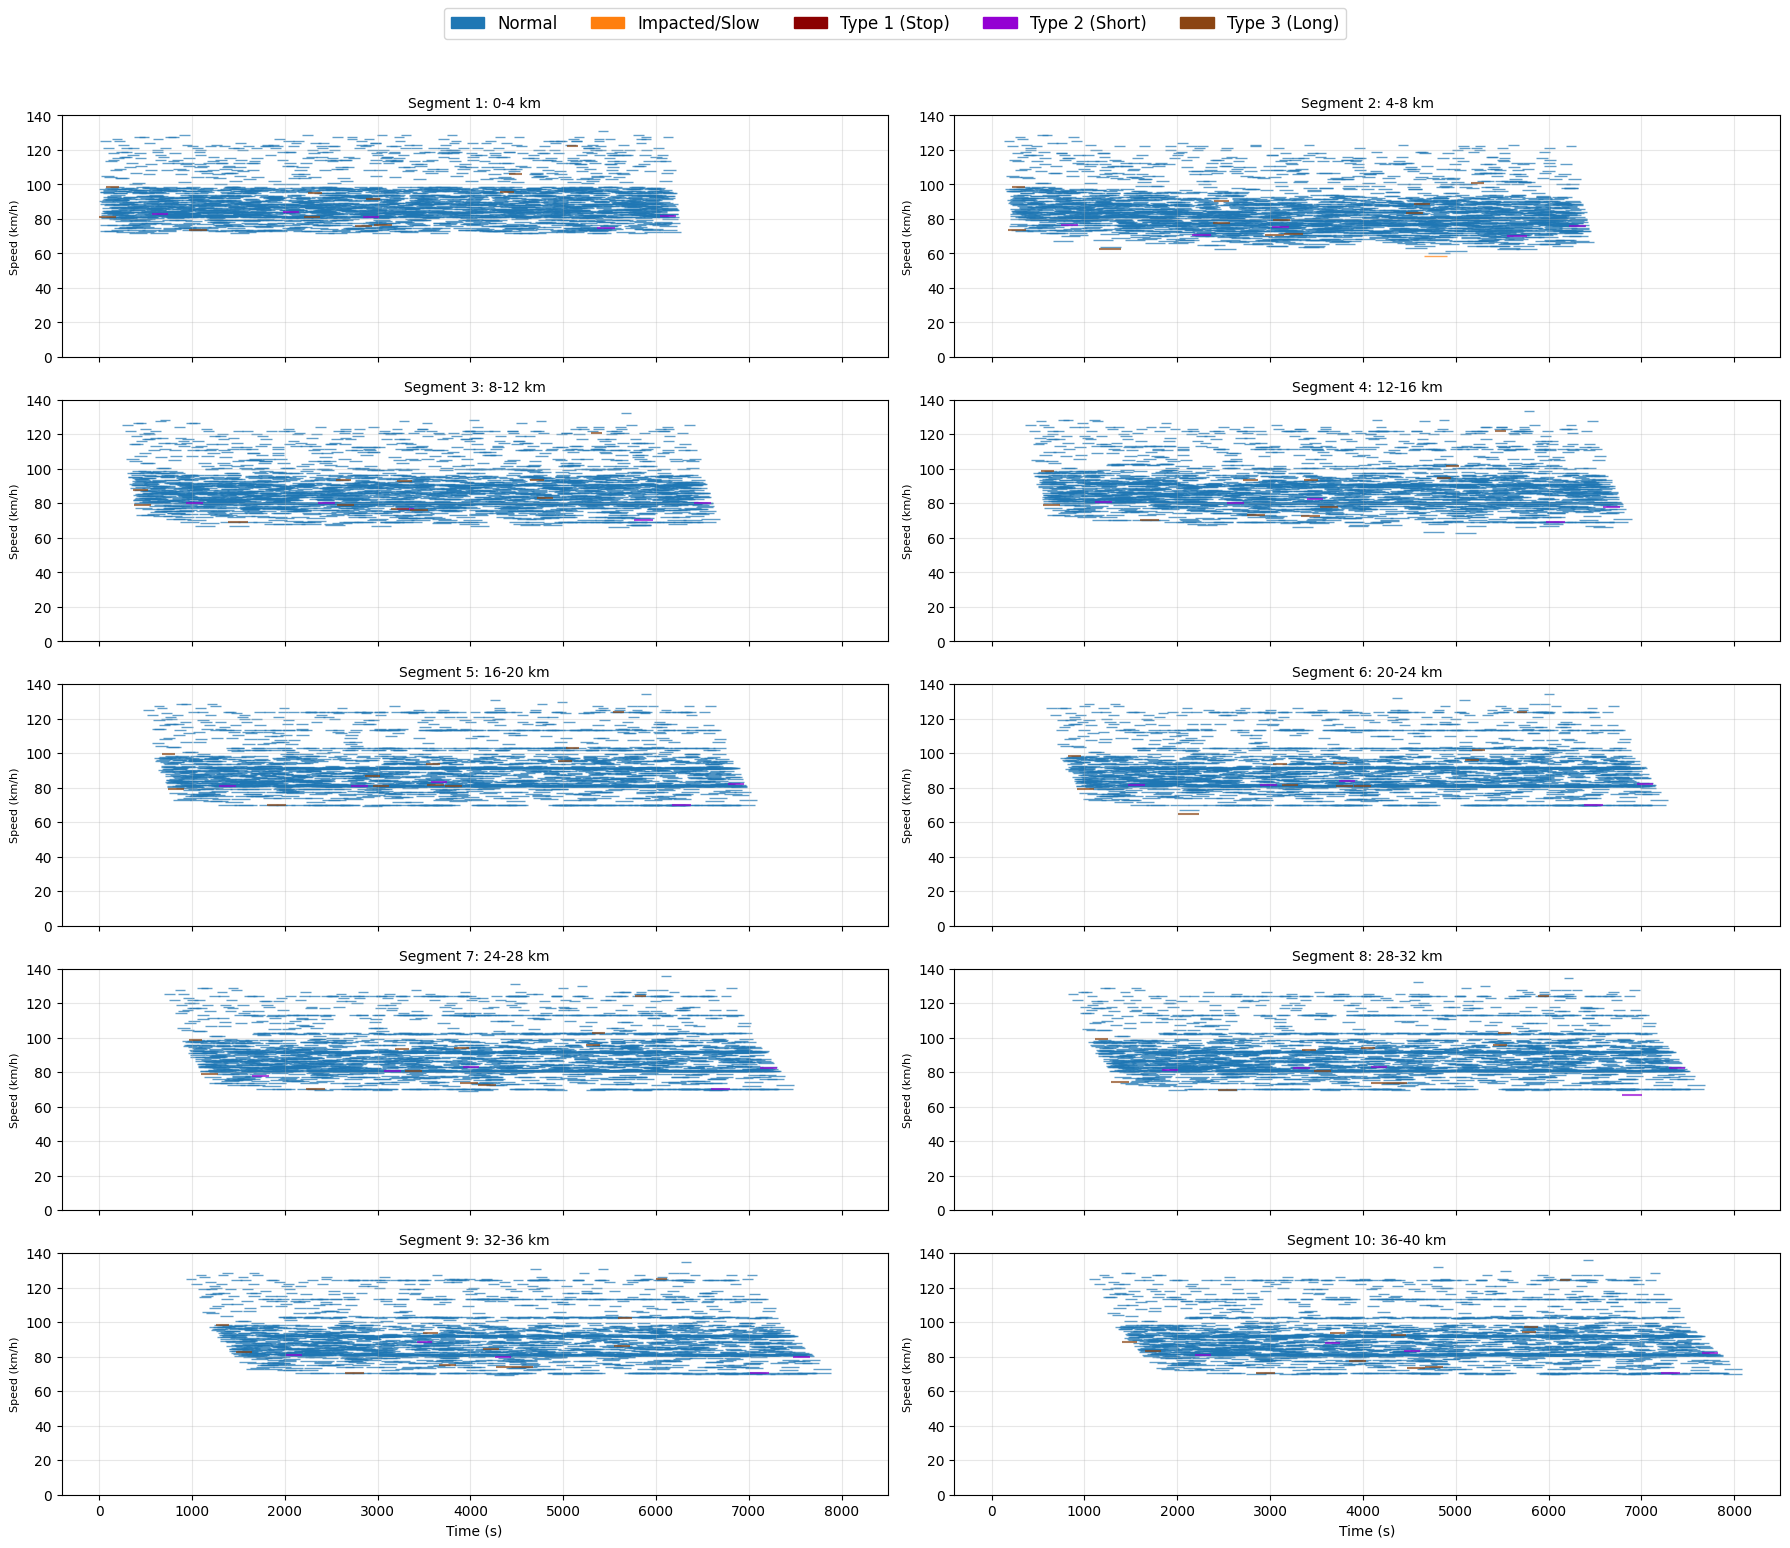

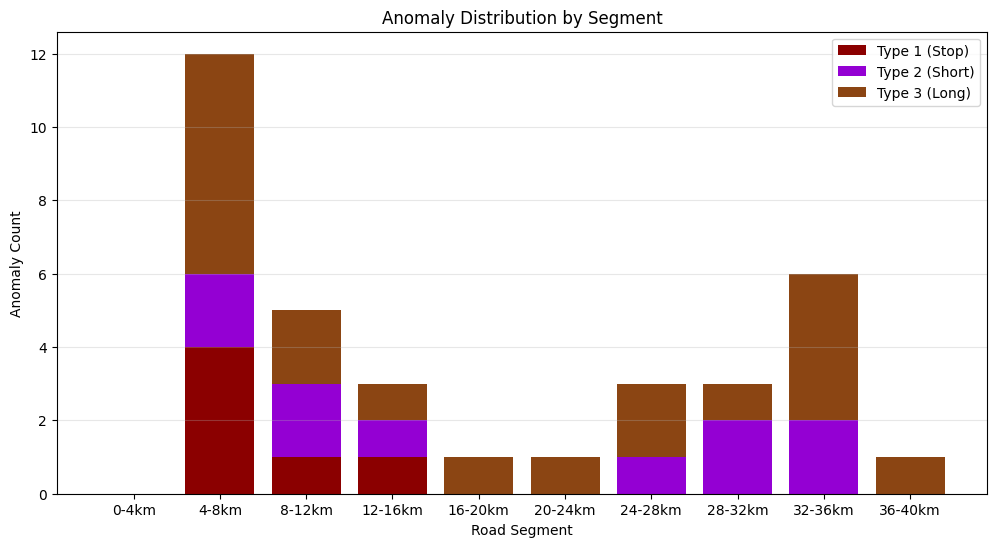


ID     | Type   | Trigger Time | Loc (km)   | State
----------------------------------------------------------------------
0      | 3      | 302.0        | 6.77       | Active
36     | 3      | 383.0        | 8.50       | Active
205    | 1      | 678.0        | 5.80       | Active
170    | 1      | 740.0        | 8.96       | Active
275    | 2      | 799.0        | 5.23       | Active
467    | 3      | 1177.0       | 4.31       | Active
0      | 3      | 1323.0       | 28.90      | Active
555    | 1      | 1377.0       | 5.52       | Active
36     | 3      | 1402.0       | 35.99      | Active
275    | 2      | 1808.0       | 27.60      | Active
740    | 1      | 1961.0       | 14.17      | Active
897    | 1      | 2106.0       | 7.90       | Active
467    | 3      | 2199.0       | 23.68      | Active
966    | 2      | 2280.0       | 6.76       | Active
1130   | 1      | 2636.0       | 7.43       | Active
1070   | 3      | 2763.0       | 12.33      | Active
1095   | 3      | 2928.0    

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import os

# --- 配置参数 (Configuration) ---
ROAD_LENGTH_KM = 40
SEGMENT_LENGTH_KM = 4
NUM_SEGMENTS = int(ROAD_LENGTH_KM / SEGMENT_LENGTH_KM)  # 10个区间
NUM_LANES = 4
TOTAL_VEHICLES_TARGET = 1200
SIMULATION_DT = 1.0  # 模拟步长 1秒

# 动力学参数 (m/s, m/s^2)
ACCEL_NORMAL = 3.0
DECEL_NORMAL = 3.0
DECEL_ANOMALY_TYPE1 = 7.0
DECEL_ANOMALY_TYPE23 = 4.0

# 速度设定 (km/h -> m/s)
def kmh_to_ms(v): return v / 3.6
def ms_to_kmh(v): return v * 3.6

SPEED_HIGH = (110, 120)
SPEED_NORMAL = (90, 90)
SPEED_LOW = (80, 80)

# 异常参数
ANOMALY_RATIO = 0.01        # 1% 的车是潜在异常车
GLOBAL_ANOMALY_START = 200  # 全局仿真时间必须 > 200s
VEHICLE_SAFE_RUN_TIME = 200 # 车辆自身必须正常跑满 200s
ANOMALY_IMPACT_DIST = 250   # 米 (后方影响范围)
TYPE1_BLOCK_DIST = 100      # 米 (前后封锁范围)
IMPACT_DISCOVER_DIST = 150  # 米 (发现异常车的距离)
LANE_CHANGE_DELAY = 2.0     # 秒 (换道延迟触发时间)
SLOWDOWN_RATIO = 0.85       # 减速叠加比例

# 颜色定义
COLOR_NORMAL = '#1f77b4'  # Blue
COLOR_IMPACTED = '#ff7f0e' # Orange
COLOR_TYPE1 = '#8b0000'    # Dark Red (完全静止)
COLOR_TYPE2 = '#9400d3'    # Purple (短暂)
COLOR_TYPE3 = '#8b4513'    # Saddle Brown (长时)

# --- 车辆类 (Vehicle Class) ---
class Vehicle:
    def __init__(self, v_id, entry_time, lane):
        self.id = v_id
        self.lane = lane # 0, 1, 2, 3
        self.pos = 0.0   # meters
        
        # 速度初始化
        r = random.random()
        if r < 0.15: # 高速
            base_speed = random.uniform(*SPEED_HIGH)
        elif r < 0.75: # 正常
            base_speed = random.uniform(*SPEED_NORMAL)
        else: # 低速
            base_speed = random.uniform(*SPEED_LOW)
        
        # 初始速度波动 +/- 10%
        self.desired_speed = kmh_to_ms(base_speed * random.uniform(0.9, 1.1))
        self.speed = self.desired_speed
        
        # 异常属性
        self.is_potential_anomaly = (random.random() < ANOMALY_RATIO)
        self.anomaly_type = 0 # 0:None, 1:Stop, 2:Short, 3:Long
        self.anomaly_state = 'normal' # normal, active, cooling
        self.anomaly_timer = 0
        self.cooldown_timer = 0
        self.color = COLOR_NORMAL
        
        # 记录数据
        self.logs = {} 
        self.current_segment = 0
        self.entry_time = entry_time
        self.finished = False

        self.lane_change_cooldown = 0
        self.discover_time = None  # 发现异常车的时间戳
        self.impact_count = 0      # 周围异常源数量（用于减速叠加）
        self.lane_change_pending = False  # 是否在等待换道延迟
        self.lane_change_wait_start = 0   # 换道等待开始时间

    def trigger_anomaly(self, current_time, segment_idx):
        """尝试触发异常状态机 (修复后的逻辑)"""
        # 1. 基础资格检查
        if not self.is_potential_anomaly: return None
        if self.anomaly_state == 'active': return None
        
        # 2. 冷却期检查
        if self.anomaly_state == 'cooling':
            self.cooldown_timer -= 1
            if self.cooldown_timer <= 0:
                self.anomaly_state = 'normal' # 冷却结束，允许复发
            else:
                return None # 还在冷却中

        # 3. 时间门槛检查 (核心修复点)
        # 全局时间必须 > 200s
        if current_time < GLOBAL_ANOMALY_START: return None
        # 车辆自身必须正常运行了 200s (避免刚进场就坏)
        if (current_time - self.entry_time) < VEHICLE_SAFE_RUN_TIME: return None

        # 4. 触发判定
        trigger = False
        
        # 情况A: 第一次触发
        if self.anomaly_type == 0:
            # 这里的概率控制着"满足条件后多久触发"。
            # 0.005/s 意味着平均 200秒内会触发。防止所有满足条件的车同一秒爆炸。
            if random.random() < 0.005: 
                trigger = True
                # 随机决定异常类型
                r = random.random()
                if r < 0.33: self.anomaly_type = 1
                elif r < 0.66: self.anomaly_type = 2
                else: self.anomaly_type = 3
                
        # 情况B: 复发 (Type 2/3)
        elif self.anomaly_type in [2, 3]: 
            # 冷却结束后，每秒 30% 概率复发
            if random.random() < 0.3: 
                trigger = True
        
        # 5. 执行触发
        if trigger:
            self.anomaly_state = 'active'
            
            if self.anomaly_type == 1:
                self.target_speed_override = 0
                self.color = COLOR_TYPE1
                self.anomaly_timer = 999999 # 永久
            elif self.anomaly_type == 2:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 10 # 持续10s
                self.color = COLOR_TYPE2
            elif self.anomaly_type == 3:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 20 # 持续20s
                self.color = COLOR_TYPE3
            
            return {
                'id': self.id,
                'type': self.anomaly_type,
                'time': current_time,
                'pos_km': self.pos / 1000.0,
                'segment': segment_idx,
                'min_speed': ms_to_kmh(self.target_speed_override)
            }
        return None

    def update(self, dt, vehicles_nearby, blocked_lanes, current_time):
        """更新车辆物理状态"""
        if self.finished: return

        # --- 状态机倒计时 ---
        target_v = self.desired_speed
        max_decel = DECEL_NORMAL
        
        if self.anomaly_state == 'active':
            target_v = self.target_speed_override
            if self.anomaly_type == 1: max_decel = DECEL_ANOMALY_TYPE1
            else: max_decel = DECEL_ANOMALY_TYPE23
            
            self.anomaly_timer -= dt
            # 异常结束恢复
            if self.anomaly_timer <= 0 and self.anomaly_type != 1:
                self.anomaly_state = 'cooling'
                self.cooldown_timer = 1000 # 冷却1000s
                self.color = COLOR_NORMAL
        
        # --- 交互逻辑 (前车判定) ---
        leader = None
        min_dist = 99999
        
        for other in vehicles_nearby:
            if other.lane == self.lane and other.pos > self.pos:
                dist = other.pos - self.pos
                if dist < min_dist:
                    min_dist = dist
                    leader = other
        
        # --- 异常影响 & Type 1 封锁 ---
        impacted_by_anomaly = False
        
        # 统计周围±150m内异常源数量（用于减速叠加）
        anomaly_sources_nearby = 0
        for other in vehicles_nearby:
            if other != self and other.anomaly_state == 'active':
                dist = abs(other.pos - self.pos)
                if dist < IMPACT_DISCOVER_DIST:  # ±150m范围内
                    anomaly_sources_nearby += 1
        
        # 应用85%减速叠加
        if anomaly_sources_nearby > 0:
            slowdown_factor = SLOWDOWN_RATIO ** anomaly_sources_nearby
            target_v = target_v * slowdown_factor
            impacted_by_anomaly = True
        
        if leader:
            # Type 1 封锁
            if leader.anomaly_type == 1 and min_dist < TYPE1_BLOCK_DIST + 50:
                target_v = 0
                max_decel = DECEL_ANOMALY_TYPE1
            # Type 2/3 影响
            elif leader.anomaly_state == 'active' and min_dist < ANOMALY_IMPACT_DIST:
                target_v = min(target_v, leader.speed * 0.8)
                impacted_by_anomaly = True
        
        # --- 换道逻辑 (2s延迟触发机制) ---
        self.lane_change_cooldown -= dt
        
        # 检查是否需要进入换道等待状态（同车道发现异常车）
        want_change = False
        if leader:
            safe_following_dist = self.speed * 2 + 15
            # 前方有Type1 或 距离过近触发换道
            if (min_dist < safe_following_dist) or (leader.anomaly_type == 1 and min_dist < 200):
                want_change = True
        
        # 同车道处理：发现异常后进入2s倒计时
        if leader and leader.anomaly_state == 'active' and leader.lane == self.lane and min_dist < IMPACT_DISCOVER_DIST:
            if not self.lane_change_pending:
                self.lane_change_pending = True
                self.lane_change_wait_start = current_time
        
        # 检查2s延迟是否结束
        if self.lane_change_pending:
            if current_time - self.lane_change_wait_start >= LANE_CHANGE_DELAY:
                self.lane_change_pending = False
                # 延迟结束后执行换道判断
                if want_change and self.lane_change_cooldown <= 0:
                    self._execute_lane_change(vehicles_nearby, blocked_lanes)
        elif want_change and self.lane_change_cooldown <= 0:
            # 非同车道异常的换道直接执行
            self._execute_lane_change(vehicles_nearby, blocked_lanes)

        # --- 颜色更新 ---
        if self.anomaly_state != 'active':
            if impacted_by_anomaly or (leader and min_dist < 40 and self.speed < 20):
                self.color = COLOR_IMPACTED
            else:
                self.color = COLOR_NORMAL

        # --- 物理积分 ---
        if self.speed < target_v:
            self.speed += ACCEL_NORMAL * dt
        elif self.speed > target_v:
            self.speed -= max_decel * dt
        if self.speed < 0: self.speed = 0
        
        self.pos += self.speed * dt
        
        # --- 数据记录 ---
        # 注意：这里不应该更新记录，应该在 record_time 中统一处理
        # seg_idx 的计算移到 record_time 调用之前
            
    def _execute_lane_change(self, vehicles_nearby, blocked_lanes):
        """执行换道操作"""
        options = []
        if self.lane > 0: options.append(self.lane - 1)
        if self.lane < NUM_LANES - 1: options.append(self.lane + 1)
        
        random.shuffle(options)
        for target_lane in options:
            safe = True
            # 检查Type 1 封锁
            if target_lane in blocked_lanes:
                for block_pos in blocked_lanes[target_lane]:
                    if abs(block_pos - self.pos) < TYPE1_BLOCK_DIST:
                        safe = False; break
            if not safe: continue

            # 检查目标车道空隙
            for other in vehicles_nearby:
                if other.lane == target_lane:
                    if abs(other.pos - self.pos) < 35: # 间距
                        safe = False; break
            
            if safe:
                self.lane = target_lane
                self.lane_change_cooldown = 5.0
                break
    
    def record_time(self, time_now, seg_idx):
        """记录车辆在各区间的时间"""
        if seg_idx >= NUM_SEGMENTS: 
            self.finished = True
            # 离开最后一个区间时，更新最后区间的 out 时间
            if self.current_segment < NUM_SEGMENTS and self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            return
        
        # 如果进入了新区间
        if seg_idx != self.current_segment:
            # 更新旧区间的离开时间
            if self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            
            # 记录新区间的进入时间
            self.current_segment = seg_idx
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
        else:
            # 在当前区间内，持续更新 out 时间
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
            else:
                self.logs[seg_idx]['out'] = time_now

# --- 仿真主程序 ---
class TrafficSimulation:
    def __init__(self):
        self.vehicles = []
        self.finished_vehicles = []
        self.current_time = 0
        self.vehicle_id_counter = 0
        self.anomaly_logs = []
        self.spawn_schedule = []
        self.plan_spawns()
        
    def plan_spawns(self):
        """生成随机投放计划：每10s随机2-8辆"""
        total_generated = 0
        t_cycle = 0
        while total_generated < TOTAL_VEHICLES_TARGET:
            n = random.randint(2, 8) # 随机数量
            if total_generated + n > TOTAL_VEHICLES_TARGET:
                n = TOTAL_VEHICLES_TARGET - total_generated
            
            # 在这10s内随机时间点
            timestamps = sorted([t_cycle + random.uniform(0, 10) for _ in range(n)])
            for ts in timestamps:
                self.spawn_schedule.append(ts)
            
            total_generated += n
            t_cycle += 10
            
    def run(self):
        print("仿真初始化... 目标车辆: 3000")
        spawn_idx = 0
        
        while len(self.vehicles) > 0 or spawn_idx < len(self.spawn_schedule):
            # 1. 车辆投放 (带空间冲突检测)
            while spawn_idx < len(self.spawn_schedule) and self.spawn_schedule[spawn_idx] <= self.current_time:
                lane_choice = list(range(NUM_LANES))
                random.shuffle(lane_choice)
                placed = False
                
                for lane in lane_choice:
                    clear = True
                    # 检查入口50米是否有车
                    for v in self.vehicles:
                        if v.lane == lane and v.pos < 50:
                            clear = False; break
                    if clear:
                        new_v = Vehicle(self.vehicle_id_counter, self.current_time, lane)
                        self.vehicles.append(new_v)
                        self.vehicle_id_counter += 1
                        placed = True
                        break
                
                if placed:
                    spawn_idx += 1
                else:
                    # 如果堵死，推迟到下一秒
                    self.spawn_schedule[spawn_idx] += 1.0
                    break 

            # 2. 空间索引
            active_vehicles = [v for v in self.vehicles if not v.finished]
            active_vehicles.sort(key=lambda x: x.pos)
            
            blocked_lanes = defaultdict(list)
            for v in active_vehicles:
                if v.anomaly_type == 1 and v.anomaly_state == 'active':
                    blocked_lanes[v.lane].append(v.pos)

            # 3. 更新
            for v in active_vehicles:
                seg = int(v.pos / (SEGMENT_LENGTH_KM * 1000))
                v.record_time(self.current_time, seg)
                
                # 异常检测
                log = v.trigger_anomaly(self.current_time, seg)
                if log:
                    self.anomaly_logs.append(log)
                    print(f"[ALERT] ID:{log['id']:<4} Type:{log['type']} Time:{log['time']:.0f}s Loc:{log['pos_km']:.2f}km")

                v.update(SIMULATION_DT, active_vehicles, blocked_lanes, self.current_time)

            # 4. 清理
            completed = [v for v in self.vehicles if v.finished]
            self.finished_vehicles.extend(completed)
            self.vehicles = [v for v in self.vehicles if not v.finished]
            
            self.current_time += SIMULATION_DT
            
            if int(self.current_time) % 200 == 0:
                print(f"Time: {int(self.current_time)}s | Active: {len(self.vehicles)} | Done: {len(self.finished_vehicles)}")
                # 超时保护 (比如3小时)
                if self.current_time > 10800: break
            
            # 每1000s保存一次快照
            if int(self.current_time) % 1000 == 0 and int(self.current_time) > 0:
                save_snapshot(self.finished_vehicles, self.anomaly_logs, self.current_time)

        print("仿真完成。")

# --- 可视化模块 ---
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_snapshot(finished_vehicles, anomaly_logs, current_time):
    """保存中间快照图"""
    if len(finished_vehicles) == 0:
        return
    
    print(f"正在保存 {int(current_time)}s 时刻快照...")
    
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                if t_out - t_in < 0.1: 
                    continue
                
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    
    # 保存PNG
    filename = os.path.join(OUTPUT_DIR, f"traffic_snapshot_{int(current_time)}s.png")
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    print(f"已保存: {filename}")
    plt.close()

def plot_results(finished_vehicles, anomaly_logs):
    print("正在渲染图表 (可能需要几秒钟)...")
    print(f"完成车辆数: {len(finished_vehicles)}")
    print(f"异常事件数: {len(anomaly_logs)}")
    
    # 统计有记录的车辆数
    vehicles_with_logs = sum(1 for v in finished_vehicles if len(v.logs) > 0)
    print(f"有区间记录的车辆数: {vehicles_with_logs}")
    
    # 统计每个区间的记录数
    segment_counts = [0] * NUM_SEGMENTS
    for v in finished_vehicles:
        for seg_idx in v.logs:
            if seg_idx < NUM_SEGMENTS:
                segment_counts[seg_idx] += 1
    print(f"各区间记录数: {segment_counts}")
    
    # 1. 速度画像 (10个子图)
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                # 确保时间差有效（至少0.1秒）
                if t_out - t_in < 0.1: 
                    continue
                
                # 计算平均速度 (km/h)
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                # 限制速度范围（避免异常值）
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                # 颜色逻辑
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5 # 拥堵
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    # 图例
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

    # 2. 异常统计堆叠柱状图
    plt.figure(figsize=(12, 6))
    counts = {seg: {1:0, 2:0, 3:0} for seg in range(NUM_SEGMENTS)}
    for log in anomaly_logs:
        seg = log['segment']
        if seg < NUM_SEGMENTS:
            counts[seg][log['type']] += 1
            
    x_labels = [f"{i*4}-{(i+1)*4}km" for i in range(NUM_SEGMENTS)]
    y1 = [counts[i][1] for i in range(NUM_SEGMENTS)]
    y2 = [counts[i][2] for i in range(NUM_SEGMENTS)]
    y3 = [counts[i][3] for i in range(NUM_SEGMENTS)]
    
    x = range(len(x_labels))
    plt.bar(x, y1, color=COLOR_TYPE1, label='Type 1 (Stop)')
    plt.bar(x, y2, bottom=y1, color=COLOR_TYPE2, label='Type 2 (Short)')
    plt.bar(x, y3, bottom=[sum(x) for x in zip(y1, y2)], color=COLOR_TYPE3, label='Type 3 (Long)')
    
    plt.xlabel('Road Segment')
    plt.ylabel('Anomaly Count')
    plt.title('Anomaly Distribution by Segment')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 3. 终端打印
    print("\n" + "="*70)
    print(f"{'ID':<6} | {'Type':<6} | {'Trigger Time':<12} | {'Loc (km)':<10} | {'State'}")
    print("-" * 70)
    for log in anomaly_logs:
        print(f"{log['id']:<6} | {log['type']:<6} | {log['time']:<12.1f} | {log['pos_km']:<10.2f} | Active")
    print("="*70)

if __name__ == "__main__":
    sim = TrafficSimulation()
    sim.run()
    plot_results(sim.finished_vehicles, sim.anomaly_logs)

仿真初始化... 目标车辆: 3000
Time: 200s | Active: 94 | Done: 0
[ALERT] ID:24   Type:2 Time:320s Loc:5.25km
[ALERT] ID:70   Type:1 Time:392s Loc:6.17km
Time: 400s | Active: 176 | Done: 0
Time: 600s | Active: 291 | Done: 0
[ALERT] ID:77   Type:2 Time:616s Loc:12.83km
[ALERT] ID:166  Type:2 Time:667s Loc:8.34km
[ALERT] ID:173  Type:1 Time:726s Loc:8.28km
Time: 800s | Active: 389 | Done: 0
Time: 1000s | Active: 481 | Done: 0
[ALERT] ID:367  Type:1 Time:1097s Loc:8.56km
[ALERT] ID:328  Type:2 Time:1104s Loc:10.28km
Time: 1200s | Active: 589 | Done: 2
[ALERT] ID:521  Type:2 Time:1309s Loc:7.68km
[ALERT] ID:24   Type:2 Time:1332s Loc:24.79km
[ALERT] ID:564  Type:1 Time:1397s Loc:5.12km
Time: 1400s | Active: 679 | Done: 25
[ALERT] ID:603  Type:3 Time:1431s Loc:5.07km
Time: 1600s | Active: 742 | Done: 57
[ALERT] ID:548  Type:1 Time:1634s Loc:12.33km
[ALERT] ID:166  Type:2 Time:1676s Loc:38.18km
[ALERT] ID:681  Type:2 Time:1693s Loc:8.18km
[ALERT] ID:533  Type:1 Time:1747s Loc:13.73km
Time: 1800s | Activ

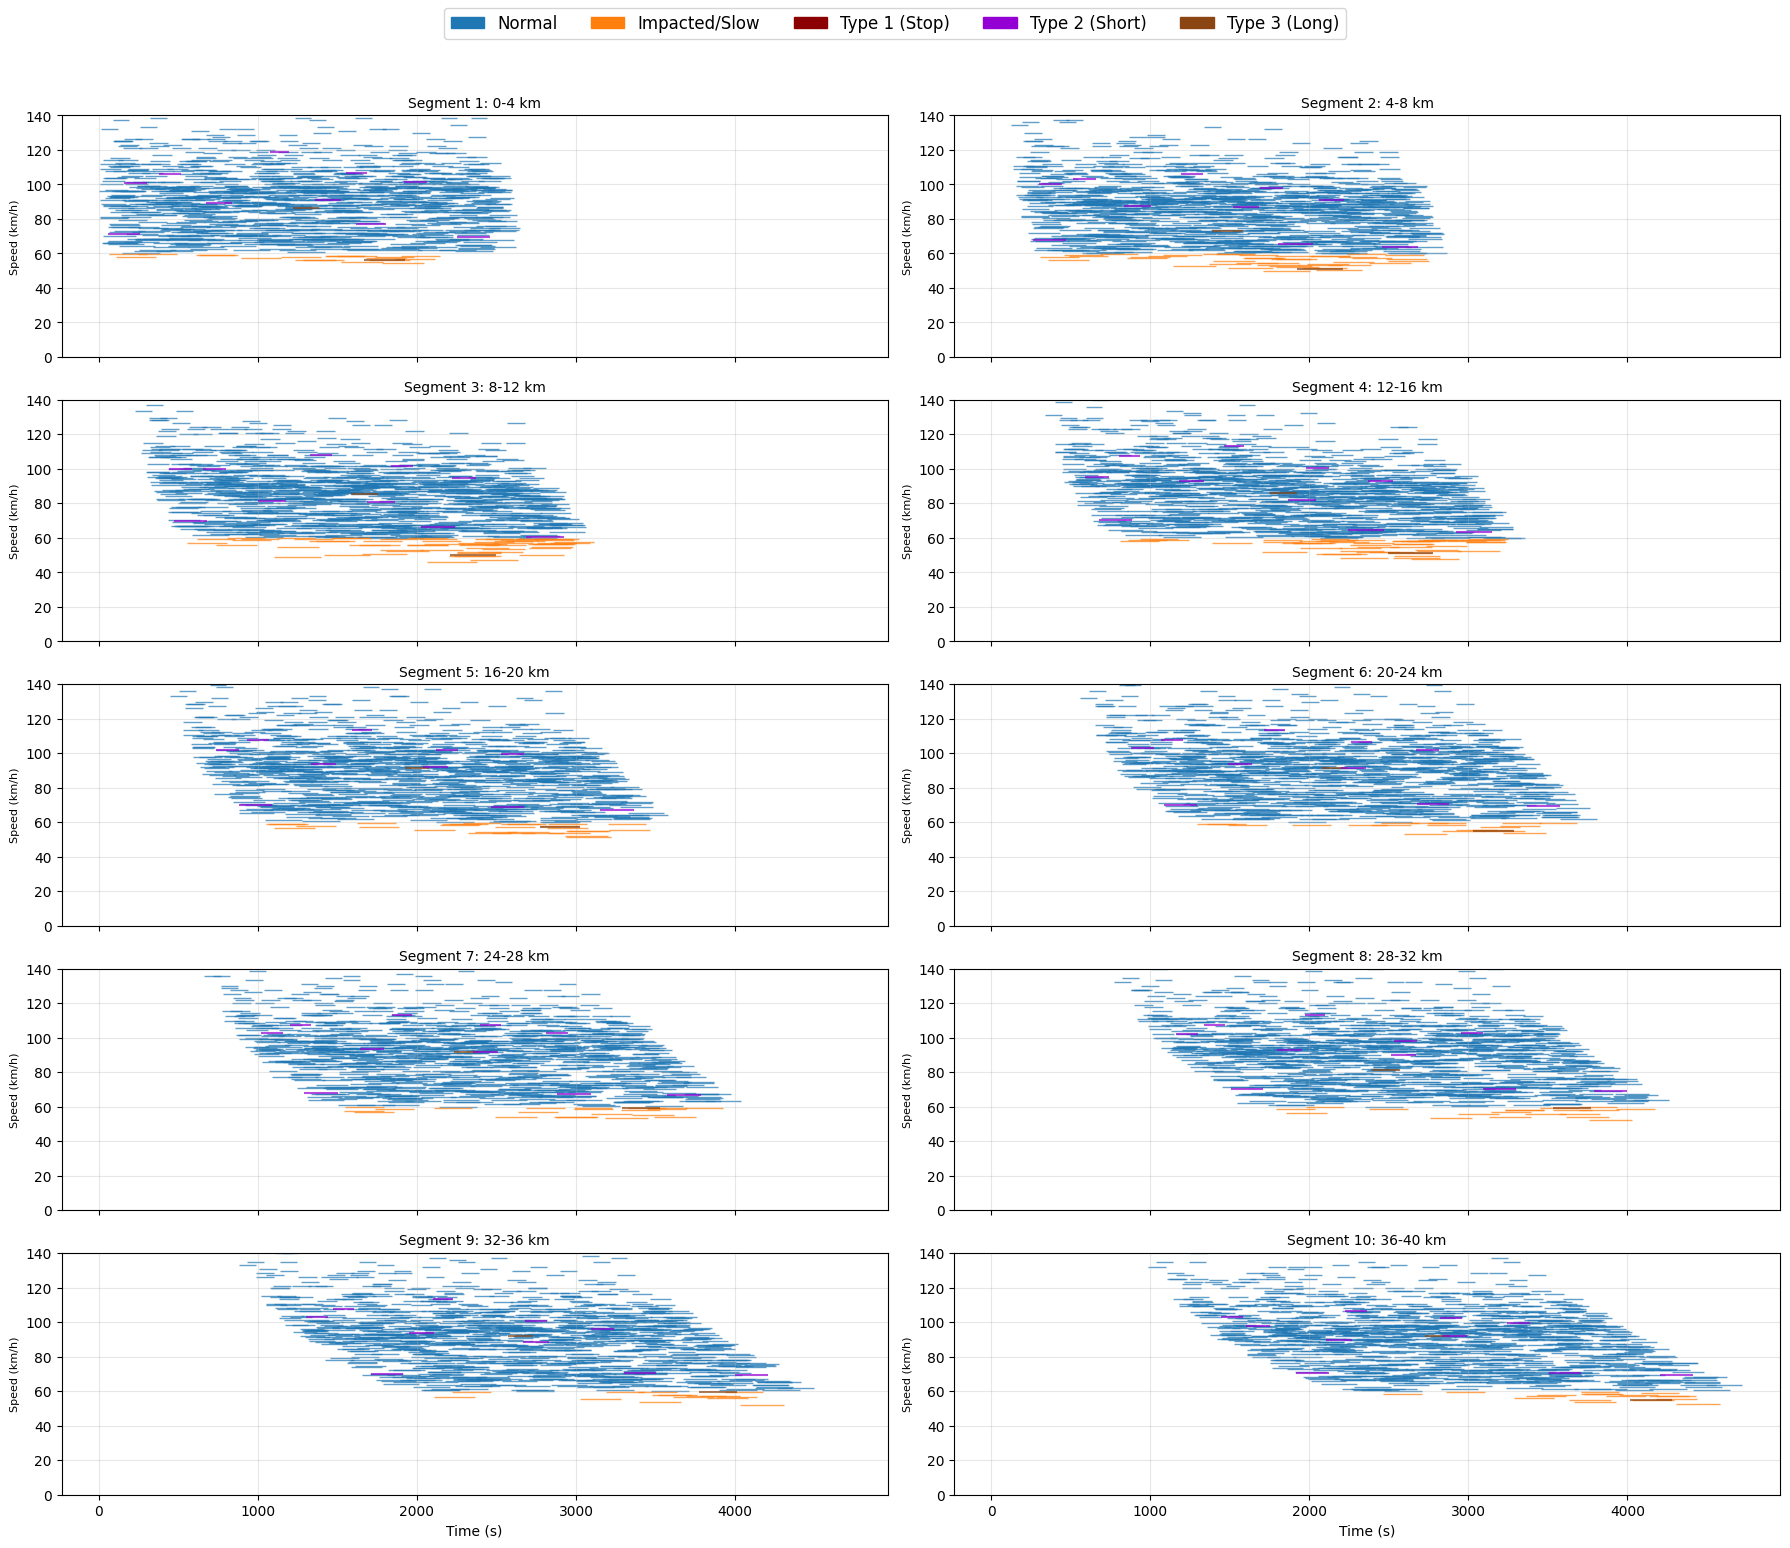

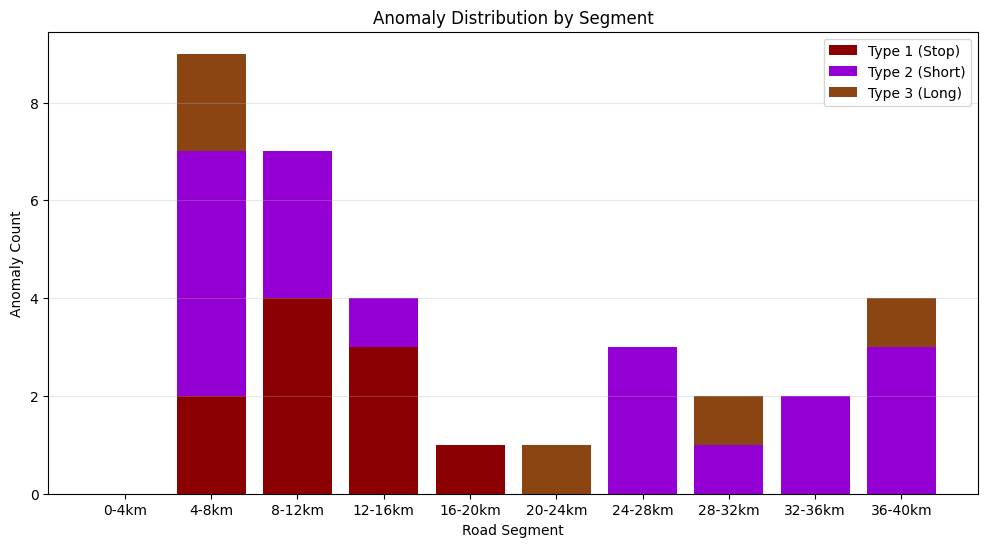


ID     | Type   | Trigger Time | Loc (km)   | State
----------------------------------------------------------------------
24     | 2      | 320.0        | 5.25       | Active
70     | 1      | 392.0        | 6.17       | Active
77     | 2      | 616.0        | 12.83      | Active
166    | 2      | 667.0        | 8.34       | Active
173    | 1      | 726.0        | 8.28       | Active
367    | 1      | 1097.0       | 8.56       | Active
328    | 2      | 1104.0       | 10.28      | Active
521    | 2      | 1309.0       | 7.68       | Active
24     | 2      | 1332.0       | 24.79      | Active
564    | 1      | 1397.0       | 5.12       | Active
603    | 3      | 1431.0       | 5.07       | Active
548    | 1      | 1634.0       | 12.33      | Active
166    | 2      | 1676.0       | 38.18      | Active
681    | 2      | 1693.0       | 8.18       | Active
533    | 1      | 1747.0       | 13.73      | Active
808    | 2      | 1888.0       | 5.39       | Active
835    | 3      | 2027.0    

In [6]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import os

# --- 配置参数 (Configuration) ---
ROAD_LENGTH_KM = 40
SEGMENT_LENGTH_KM = 4
NUM_SEGMENTS = int(ROAD_LENGTH_KM / SEGMENT_LENGTH_KM)  # 10个区间
NUM_LANES = 4
TOTAL_VEHICLES_TARGET = 1200
SIMULATION_DT = 1.0  # 模拟步长 1秒

# 动力学参数 (m/s, m/s^2)
ACCEL_NORMAL = 3.0
DECEL_NORMAL = 3.0
DECEL_ANOMALY_TYPE1 = 7.0
DECEL_ANOMALY_TYPE23 = 4.0

# 速度设定 (km/h -> m/s)
def kmh_to_ms(v): return v / 3.6
def ms_to_kmh(v): return v * 3.6

SPEED_HIGH = (110, 120)
SPEED_NORMAL = (90, 90)
SPEED_LOW = (80, 80)

# 异常参数
ANOMALY_RATIO = 0.01        # 1% 的车是潜在异常车
GLOBAL_ANOMALY_START = 200  # 全局仿真时间必须 > 200s
VEHICLE_SAFE_RUN_TIME = 200 # 车辆自身必须正常跑满 200s
ANOMALY_IMPACT_DIST = 250   # 米 (后方影响范围)
TYPE1_BLOCK_DIST = 100      # 米 (前后封锁范围)
IMPACT_DISCOVER_DIST = 150  # 米 (发现异常车的距离)
LANE_CHANGE_DELAY = 2.0     # 秒 (换道延迟触发时间)
SLOWDOWN_RATIO = 0.7        # 减速叠加比例

# 颜色定义
COLOR_NORMAL = '#1f77b4'  # Blue
COLOR_IMPACTED = '#ff7f0e' # Orange
COLOR_TYPE1 = '#8b0000'    # Dark Red (完全静止)
COLOR_TYPE2 = '#9400d3'    # Purple (短暂)
COLOR_TYPE3 = '#8b4513'    # Saddle Brown (长时)

# --- 车辆类 (Vehicle Class) ---
class Vehicle:
    def __init__(self, v_id, entry_time, lane):
        self.id = v_id
        self.lane = lane # 0, 1, 2, 3
        self.pos = 0.0   # meters
        
        # 速度初始化 - 正态分布
        r = random.random()
        if r < 0.15: # 高速 (均值115, 标准差8)
            base_speed = random.gauss(115, 8)
        elif r < 0.75: # 正常 (均值95, 标准差8)
            base_speed = random.gauss(95, 8)
        else: # 低速 (均值70, 标准差5)
            base_speed = random.gauss(70, 5)
        
        # 限制在合理范围内
        base_speed = max(50, min(140, base_speed))
        
        # 初始速度波动 +/- 10%
        self.desired_speed = kmh_to_ms(base_speed * random.uniform(0.9, 1.1))
        self.speed = self.desired_speed
        
        # 速度稳定计时器（10秒内保持速度不变）
        self.speed_stable_timer = 10.0
        
        # 异常属性
        self.is_potential_anomaly = (random.random() < ANOMALY_RATIO)
        self.anomaly_type = 0 # 0:None, 1:Stop, 2:Short, 3:Long
        self.anomaly_state = 'normal' # normal, active, cooling
        self.anomaly_timer = 0
        self.cooldown_timer = 0
        self.color = COLOR_NORMAL
        
        # 记录数据
        self.logs = {} 
        self.current_segment = 0
        self.entry_time = entry_time
        self.finished = False

        self.lane_change_cooldown = 0
        self.discover_time = None  # 发现异常车的时间戳
        self.impact_count = 0      # 周围异常源数量（用于减速叠加）
        self.lane_change_pending = False  # 是否在等待换道延迟
        self.lane_change_wait_start = 0   # 换道等待开始时间

    def trigger_anomaly(self, current_time, segment_idx):
        """尝试触发异常状态机 (修复后的逻辑)"""
        # 1. 基础资格检查
        if not self.is_potential_anomaly: return None
        if self.anomaly_state == 'active': return None
        
        # 2. 冷却期检查
        if self.anomaly_state == 'cooling':
            self.cooldown_timer -= 1
            if self.cooldown_timer <= 0:
                self.anomaly_state = 'normal' # 冷却结束，允许复发
            else:
                return None # 还在冷却中

        # 3. 时间门槛检查 (核心修复点)
        # 全局时间必须 > 200s
        if current_time < GLOBAL_ANOMALY_START: return None
        # 车辆自身必须正常运行了 200s (避免刚进场就坏)
        if (current_time - self.entry_time) < VEHICLE_SAFE_RUN_TIME: return None

        # 4. 触发判定
        trigger = False
        
        # 情况A: 第一次触发
        if self.anomaly_type == 0:
            # 这里的概率控制着"满足条件后多久触发"。
            # 0.005/s 意味着平均 200秒内会触发。防止所有满足条件的车同一秒爆炸。
            if random.random() < 0.005: 
                trigger = True
                # 随机决定异常类型
                r = random.random()
                if r < 0.33: self.anomaly_type = 1
                elif r < 0.66: self.anomaly_type = 2
                else: self.anomaly_type = 3
                
        # 情况B: 复发 (Type 2/3)
        elif self.anomaly_type in [2, 3]: 
            # 冷却结束后，每秒 30% 概率复发
            if random.random() < 0.3: 
                trigger = True
        
        # 5. 执行触发
        if trigger:
            self.anomaly_state = 'active'
            
            if self.anomaly_type == 1:
                self.target_speed_override = 0
                self.color = COLOR_TYPE1
                self.anomaly_timer = 999999 # 永久
            elif self.anomaly_type == 2:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 10 # 持续10s
                self.color = COLOR_TYPE2
            elif self.anomaly_type == 3:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 20 # 持续20s
                self.color = COLOR_TYPE3
            
            return {
                'id': self.id,
                'type': self.anomaly_type,
                'time': current_time,
                'pos_km': self.pos / 1000.0,
                'segment': segment_idx,
                'min_speed': ms_to_kmh(self.target_speed_override)
            }
        return None

    def update(self, dt, vehicles_nearby, blocked_lanes, current_time):
        """更新车辆物理状态"""
        if self.finished: return

        # --- 状态机倒计时 ---
        target_v = self.desired_speed
        max_decel = DECEL_NORMAL
        
        if self.anomaly_state == 'active':
            target_v = self.target_speed_override
            if self.anomaly_type == 1: max_decel = DECEL_ANOMALY_TYPE1
            else: max_decel = DECEL_ANOMALY_TYPE23
            
            self.anomaly_timer -= dt
            # 异常结束恢复
            if self.anomaly_timer <= 0 and self.anomaly_type != 1:
                self.anomaly_state = 'cooling'
                self.cooldown_timer = 1000 # 冷却1000s
                self.color = COLOR_NORMAL
        
        # --- 交互逻辑 (前车判定) ---
        leader = None
        min_dist = 99999
        
        for other in vehicles_nearby:
            if other.lane == self.lane and other.pos > self.pos:
                dist = other.pos - self.pos
                if dist < min_dist:
                    min_dist = dist
                    leader = other
        
        # --- 异常影响 & Type 1 封锁 ---
        impacted_by_anomaly = False
        
        # 统计周围±150m内异常源数量（用于减速叠加）
        anomaly_sources_nearby = 0
        for other in vehicles_nearby:
            if other != self and other.anomaly_state == 'active':
                dist = abs(other.pos - self.pos)
                if dist < IMPACT_DISCOVER_DIST:  # ±150m范围内
                    anomaly_sources_nearby += 1
        
        # 应用85%减速叠加
        if anomaly_sources_nearby > 0:
            slowdown_factor = SLOWDOWN_RATIO ** anomaly_sources_nearby
            target_v = target_v * slowdown_factor
            impacted_by_anomaly = True
        
        if leader:
            # Type 1 封锁
            if leader.anomaly_type == 1 and min_dist < TYPE1_BLOCK_DIST + 50:
                target_v = 0
                max_decel = DECEL_ANOMALY_TYPE1
            # Type 2/3 影响
            elif leader.anomaly_state == 'active' and min_dist < ANOMALY_IMPACT_DIST:
                target_v = min(target_v, leader.speed * 0.8)
                impacted_by_anomaly = True
        
        # --- 换道逻辑 (2s延迟触发机制) ---
        self.lane_change_cooldown -= dt
        
        # 检查是否需要进入换道等待状态（同车道发现异常车）
        want_change = False
        if leader:
            safe_following_dist = self.speed * 2 + 15
            # 前方有Type1 或 距离过近触发换道
            if (min_dist < safe_following_dist) or (leader.anomaly_type == 1 and min_dist < 200):
                want_change = True
        
        # 同车道处理：发现异常后进入2s倒计时
        if leader and leader.anomaly_state == 'active' and leader.lane == self.lane and min_dist < IMPACT_DISCOVER_DIST:
            if not self.lane_change_pending:
                self.lane_change_pending = True
                self.lane_change_wait_start = current_time
        
        # 检查2s延迟是否结束
        if self.lane_change_pending:
            if current_time - self.lane_change_wait_start >= LANE_CHANGE_DELAY:
                self.lane_change_pending = False
                # 延迟结束后执行换道判断
                if want_change and self.lane_change_cooldown <= 0:
                    self._execute_lane_change(vehicles_nearby, blocked_lanes)
        elif want_change and self.lane_change_cooldown <= 0:
            # 非同车道异常的换道直接执行
            self._execute_lane_change(vehicles_nearby, blocked_lanes)

        # --- 颜色更新 ---
        if self.anomaly_state != 'active':
            if impacted_by_anomaly or (leader and min_dist < 40 and self.speed < 20):
                self.color = COLOR_IMPACTED
            else:
                self.color = COLOR_NORMAL

        # --- 车速波动逻辑（10秒稳定期后微调） ---
        if self.anomaly_state == 'normal' and self.speed_stable_timer > 0:
            self.speed_stable_timer -= dt
        elif self.anomaly_state == 'normal' and self.speed_stable_timer <= 0:
            # 10秒后有机会微调 ±5%
            if random.random() < 0.1:  # 每秒10%概率触发微调
                adjustment = random.uniform(0.95, 1.05)
                self.speed = self.speed * adjustment
                # 重置计时器
                self.speed_stable_timer = 10.0

        # --- 物理积分 ---
        if self.speed < target_v:
            self.speed += ACCEL_NORMAL * dt
        elif self.speed > target_v:
            self.speed -= max_decel * dt
        if self.speed < 0: self.speed = 0
        
        self.pos += self.speed * dt
        
        # --- 数据记录 ---
        # 注意：这里不应该更新记录，应该在 record_time 中统一处理
        # seg_idx 的计算移到 record_time 调用之前
            
    def _execute_lane_change(self, vehicles_nearby, blocked_lanes):
        """执行换道操作"""
        options = []
        if self.lane > 0: options.append(self.lane - 1)
        if self.lane < NUM_LANES - 1: options.append(self.lane + 1)
        
        random.shuffle(options)
        for target_lane in options:
            safe = True
            # 检查Type 1 封锁
            if target_lane in blocked_lanes:
                for block_pos in blocked_lanes[target_lane]:
                    if abs(block_pos - self.pos) < TYPE1_BLOCK_DIST:
                        safe = False; break
            if not safe: continue

            # 检查目标车道空隙
            for other in vehicles_nearby:
                if other.lane == target_lane:
                    if abs(other.pos - self.pos) < 35: # 间距
                        safe = False; break
            
            if safe:
                self.lane = target_lane
                self.lane_change_cooldown = 5.0
                break
    
    def record_time(self, time_now, seg_idx):
        """记录车辆在各区间的时间"""
        if seg_idx >= NUM_SEGMENTS: 
            self.finished = True
            # 离开最后一个区间时，更新最后区间的 out 时间
            if self.current_segment < NUM_SEGMENTS and self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            return
        
        # 如果进入了新区间
        if seg_idx != self.current_segment:
            # 更新旧区间的离开时间
            if self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            
            # 记录新区间的进入时间
            self.current_segment = seg_idx
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
        else:
            # 在当前区间内，持续更新 out 时间
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
            else:
                self.logs[seg_idx]['out'] = time_now

# --- 仿真主程序 ---
class TrafficSimulation:
    def __init__(self):
        self.vehicles = []
        self.finished_vehicles = []
        self.current_time = 0
        self.vehicle_id_counter = 0
        self.anomaly_logs = []
        self.spawn_schedule = []
        self.plan_spawns()
        
    def plan_spawns(self):
        """生成随机投放计划：每10s随机2-8辆"""
        total_generated = 0
        t_cycle = 0
        while total_generated < TOTAL_VEHICLES_TARGET:
            n = random.randint(2, 8) # 随机数量
            if total_generated + n > TOTAL_VEHICLES_TARGET:
                n = TOTAL_VEHICLES_TARGET - total_generated
            
            # 在这10s内随机时间点
            timestamps = sorted([t_cycle + random.uniform(0, 10) for _ in range(n)])
            for ts in timestamps:
                self.spawn_schedule.append(ts)
            
            total_generated += n
            t_cycle += 10
            
    def run(self):
        print("仿真初始化... 目标车辆: 1200")
        spawn_idx = 0
        
        while len(self.vehicles) > 0 or spawn_idx < len(self.spawn_schedule):
            # 1. 车辆投放 (带空间冲突检测)
            while spawn_idx < len(self.spawn_schedule) and self.spawn_schedule[spawn_idx] <= self.current_time:
                lane_choice = list(range(NUM_LANES))
                random.shuffle(lane_choice)
                placed = False
                
                for lane in lane_choice:
                    clear = True
                    # 检查入口50米是否有车
                    for v in self.vehicles:
                        if v.lane == lane and v.pos < 50:
                            clear = False; break
                    if clear:
                        new_v = Vehicle(self.vehicle_id_counter, self.current_time, lane)
                        self.vehicles.append(new_v)
                        self.vehicle_id_counter += 1
                        placed = True
                        break
                
                if placed:
                    spawn_idx += 1
                else:
                    # 如果堵死，推迟到下一秒
                    self.spawn_schedule[spawn_idx] += 1.0
                    break 

            # 2. 空间索引
            active_vehicles = [v for v in self.vehicles if not v.finished]
            active_vehicles.sort(key=lambda x: x.pos)
            
            blocked_lanes = defaultdict(list)
            for v in active_vehicles:
                if v.anomaly_type == 1 and v.anomaly_state == 'active':
                    blocked_lanes[v.lane].append(v.pos)

            # 3. 更新
            for v in active_vehicles:
                seg = int(v.pos / (SEGMENT_LENGTH_KM * 1000))
                v.record_time(self.current_time, seg)
                
                # 异常检测
                log = v.trigger_anomaly(self.current_time, seg)
                if log:
                    self.anomaly_logs.append(log)
                    print(f"[ALERT] ID:{log['id']:<4} Type:{log['type']} Time:{log['time']:.0f}s Loc:{log['pos_km']:.2f}km")

                v.update(SIMULATION_DT, active_vehicles, blocked_lanes, self.current_time)

            # 4. 清理
            completed = [v for v in self.vehicles if v.finished]
            self.finished_vehicles.extend(completed)
            self.vehicles = [v for v in self.vehicles if not v.finished]
            
            self.current_time += SIMULATION_DT
            
            if int(self.current_time) % 200 == 0:
                print(f"Time: {int(self.current_time)}s | Active: {len(self.vehicles)} | Done: {len(self.finished_vehicles)}")
                # 超时保护 (比如3小时)
                if self.current_time > 10800: break
            
            # 每1000s保存一次快照
            if int(self.current_time) % 1000 == 0 and int(self.current_time) > 0:
                save_snapshot(self.finished_vehicles, self.anomaly_logs, self.current_time)

        print("仿真完成。")

# --- 可视化模块 ---
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_snapshot(finished_vehicles, anomaly_logs, current_time):
    """保存中间快照图"""
    if len(finished_vehicles) == 0:
        return
    
    print(f"正在保存 {int(current_time)}s 时刻快照...")
    
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                if t_out - t_in < 0.1: 
                    continue
                
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    
    # 保存PNG
    filename = os.path.join(OUTPUT_DIR, f"traffic_snapshot_{int(current_time)}s.png")
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    print(f"已保存: {filename}")
    plt.close()

def plot_results(finished_vehicles, anomaly_logs):
    print("正在渲染图表 (可能需要几秒钟)...")
    print(f"完成车辆数: {len(finished_vehicles)}")
    print(f"异常事件数: {len(anomaly_logs)}")
    
    # 统计有记录的车辆数
    vehicles_with_logs = sum(1 for v in finished_vehicles if len(v.logs) > 0)
    print(f"有区间记录的车辆数: {vehicles_with_logs}")
    
    # 统计每个区间的记录数
    segment_counts = [0] * NUM_SEGMENTS
    for v in finished_vehicles:
        for seg_idx in v.logs:
            if seg_idx < NUM_SEGMENTS:
                segment_counts[seg_idx] += 1
    print(f"各区间记录数: {segment_counts}")
    
    # 1. 速度画像 (10个子图)
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                # 确保时间差有效（至少0.1秒）
                if t_out - t_in < 0.1: 
                    continue
                
                # 计算平均速度 (km/h)
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                # 限制速度范围（避免异常值）
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                # 颜色逻辑
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5 # 拥堵
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    # 图例
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

    # 2. 异常统计堆叠柱状图
    plt.figure(figsize=(12, 6))
    counts = {seg: {1:0, 2:0, 3:0} for seg in range(NUM_SEGMENTS)}
    for log in anomaly_logs:
        seg = log['segment']
        if seg < NUM_SEGMENTS:
            counts[seg][log['type']] += 1
            
    x_labels = [f"{i*4}-{(i+1)*4}km" for i in range(NUM_SEGMENTS)]
    y1 = [counts[i][1] for i in range(NUM_SEGMENTS)]
    y2 = [counts[i][2] for i in range(NUM_SEGMENTS)]
    y3 = [counts[i][3] for i in range(NUM_SEGMENTS)]
    
    x = range(len(x_labels))
    plt.bar(x, y1, color=COLOR_TYPE1, label='Type 1 (Stop)')
    plt.bar(x, y2, bottom=y1, color=COLOR_TYPE2, label='Type 2 (Short)')
    plt.bar(x, y3, bottom=[sum(x) for x in zip(y1, y2)], color=COLOR_TYPE3, label='Type 3 (Long)')
    
    plt.xlabel('Road Segment')
    plt.ylabel('Anomaly Count')
    plt.title('Anomaly Distribution by Segment')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 3. 终端打印
    print("\n" + "="*70)
    print(f"{'ID':<6} | {'Type':<6} | {'Trigger Time':<12} | {'Loc (km)':<10} | {'State'}")
    print("-" * 70)
    for log in anomaly_logs:
        print(f"{log['id']:<6} | {log['type']:<6} | {log['time']:<12.1f} | {log['pos_km']:<10.2f} | Active")
    print("="*70)

if __name__ == "__main__":
    sim = TrafficSimulation()
    sim.run()
    plot_results(sim.finished_vehicles, sim.anomaly_logs)

仿真初始化... 目标车辆: 1200
Time: 200s | Active: 111 | Done: 0
[ALERT] ID:21   Type:2 Time:384s Loc:9.28km
Time: 400s | Active: 202 | Done: 0
[ALERT] ID:29   Type:1 Time:500s Loc:8.89km
Time: 600s | Active: 313 | Done: 0
Time: 800s | Active: 378 | Done: 31
Time: 1000s | Active: 417 | Done: 99
正在保存 1000s 时刻快照...
已保存: output\traffic_snapshot_1000s.png
Time: 1200s | Active: 402 | Done: 204
[ALERT] ID:439  Type:3 Time:1328s Loc:13.67km
Time: 1400s | Active: 405 | Done: 292
[ALERT] ID:449  Type:3 Time:1431s Loc:17.04km
Time: 1600s | Active: 398 | Done: 403
Time: 1800s | Active: 413 | Done: 500
[ALERT] ID:770  Type:1 Time:1897s Loc:6.82km
Time: 2000s | Active: 424 | Done: 594
正在保存 2000s 时刻快照...
已保存: output\traffic_snapshot_2000s.png
[ALERT] ID:917  Type:1 Time:2086s Loc:4.32km
Time: 2200s | Active: 425 | Done: 692
Time: 2400s | Active: 406 | Done: 790
Time: 2600s | Active: 298 | Done: 902
Time: 2800s | Active: 205 | Done: 995
Time: 3000s | Active: 108 | Done: 1092
正在保存 3000s 时刻快照...
已保存: output\traf

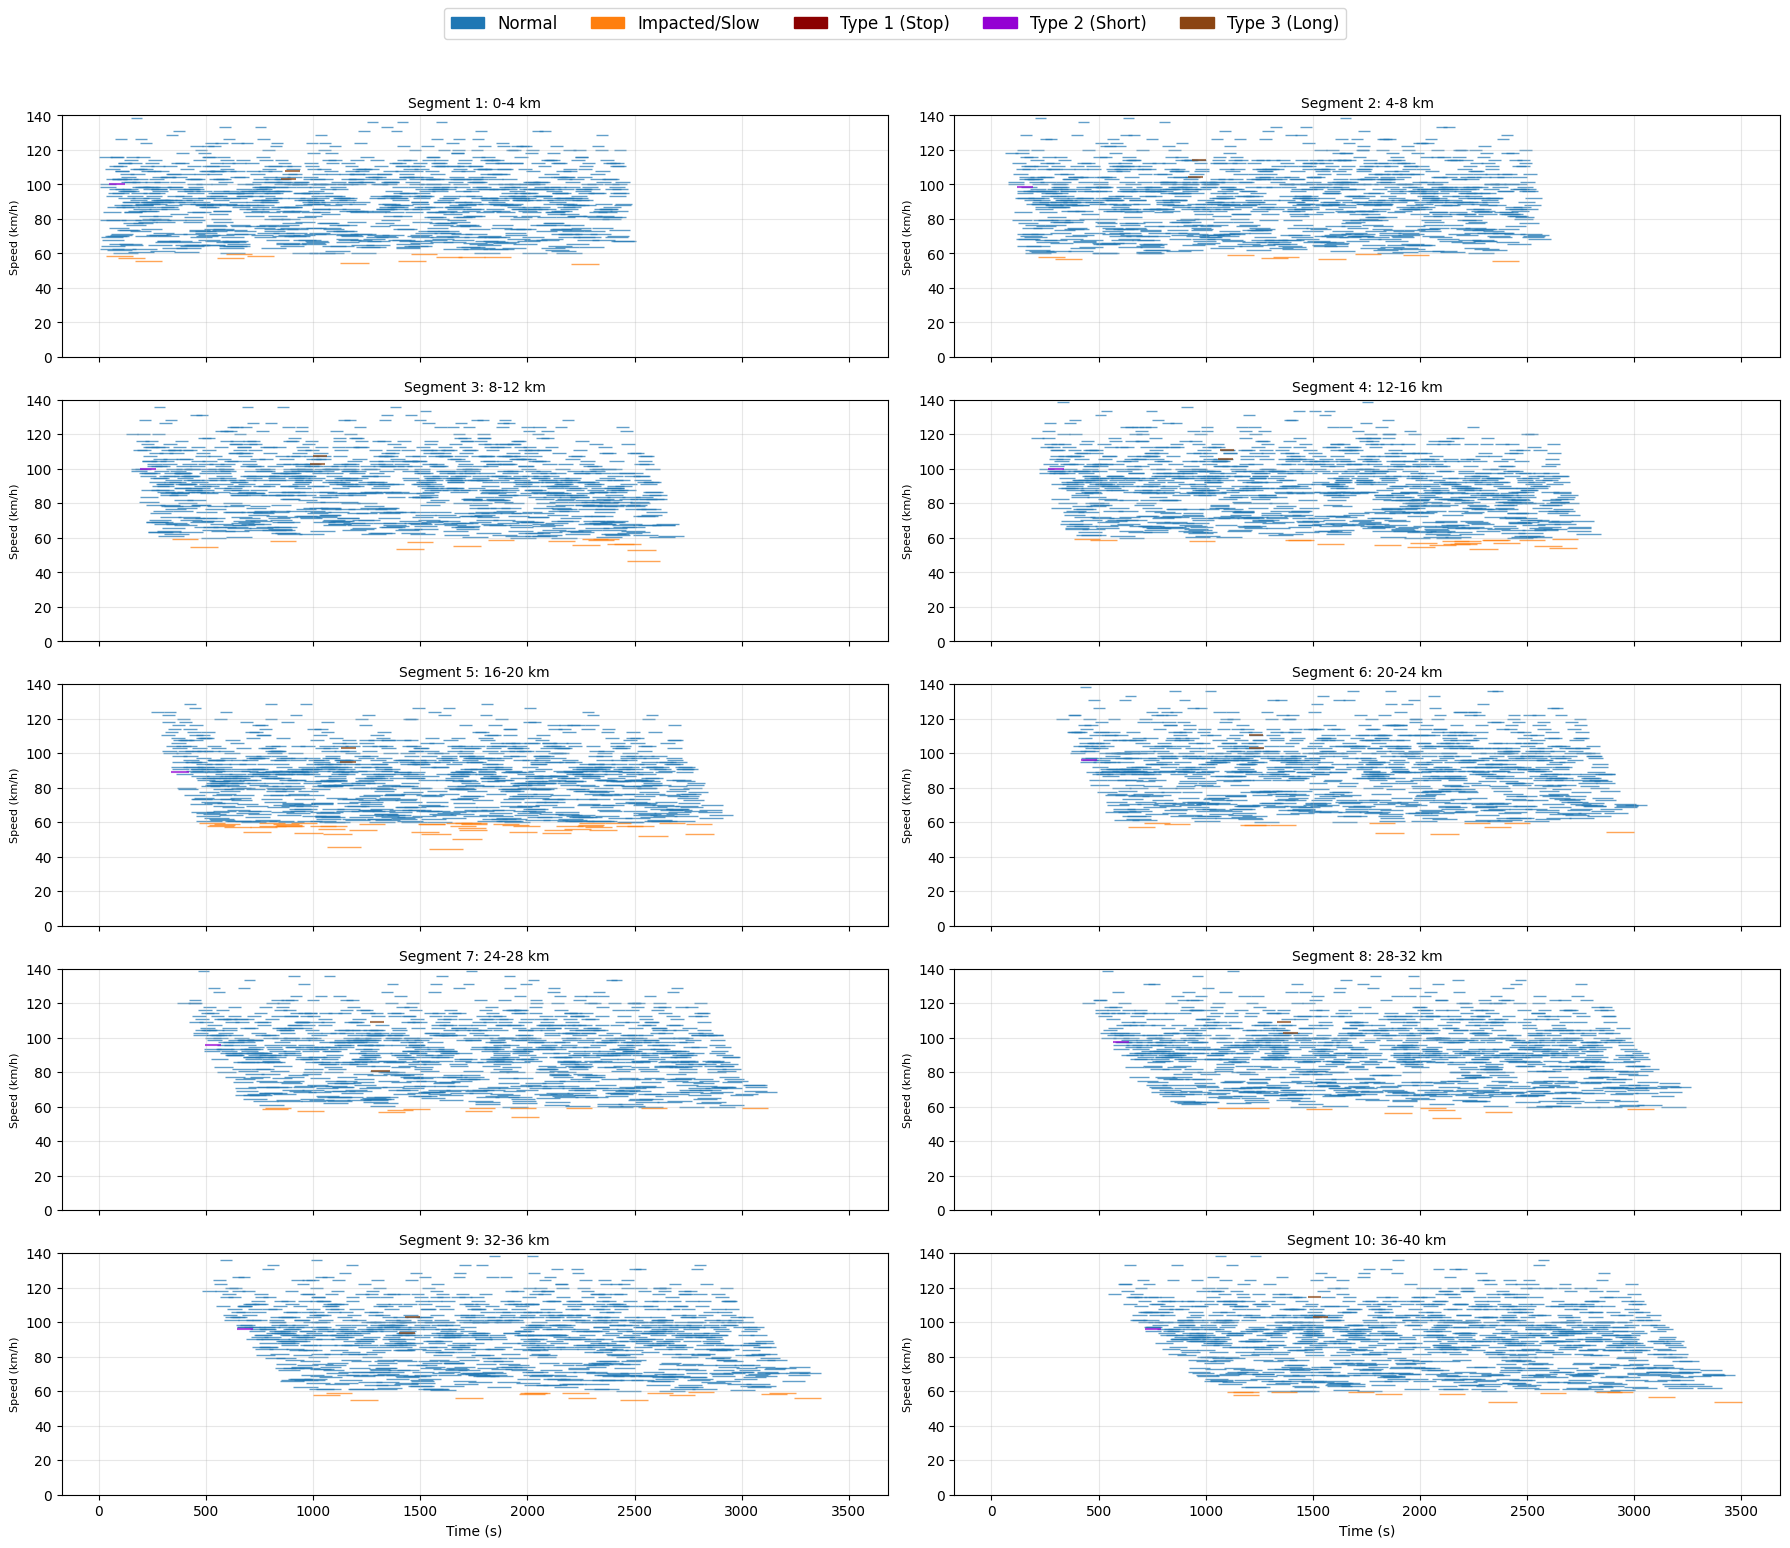

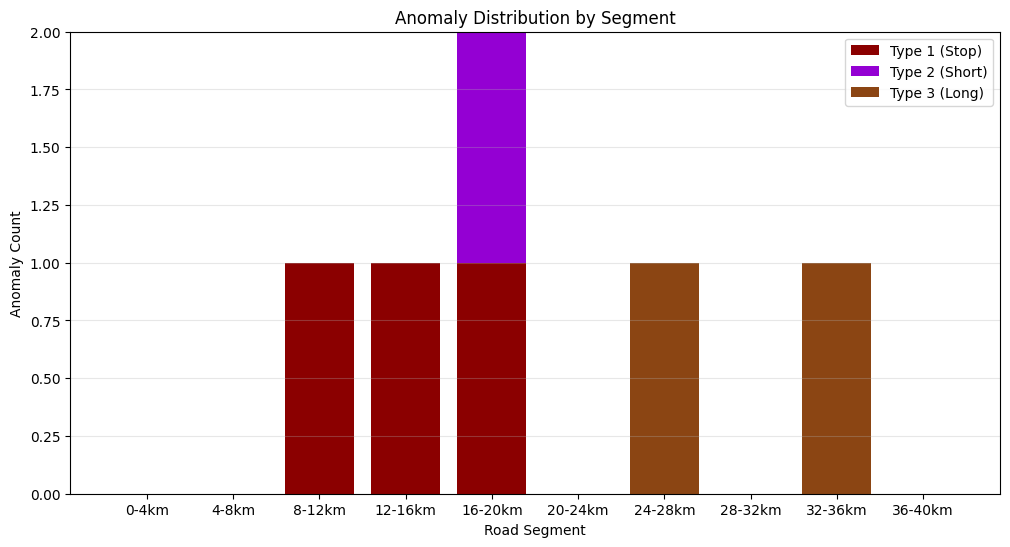


ID     | Type   | Trigger Time | Loc (km)   | State
----------------------------------------------------------------------
21     | 2      | 384.0        | 9.28       | Active
29     | 1      | 500.0        | 8.89       | Active
439    | 3      | 1328.0       | 13.67      | Active
449    | 3      | 1431.0       | 17.04      | Active
770    | 1      | 1897.0       | 6.82       | Active
917    | 1      | 2086.0       | 4.32       | Active


In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import os

# --- 配置参数 (Configuration) ---
ROAD_LENGTH_KM = 20
SEGMENT_LENGTH_KM = 2
NUM_SEGMENTS = int(ROAD_LENGTH_KM / SEGMENT_LENGTH_KM)  # 10个区间
NUM_LANES = 4
TOTAL_VEHICLES_TARGET = 1200
SIMULATION_DT = 1.0  # 模拟步长 1秒

# 动力学参数 (m/s, m/s^2)
ACCEL_NORMAL = 3.0
DECEL_NORMAL = 3.0
DECEL_ANOMALY_TYPE1 = 7.0
DECEL_ANOMALY_TYPE23 = 4.0

# 速度设定 (km/h -> m/s)
def kmh_to_ms(v): return v / 3.6
def ms_to_kmh(v): return v * 3.6

SPEED_HIGH = (110, 120)
SPEED_NORMAL = (90, 90)
SPEED_LOW = (80, 80)

# 异常参数
ANOMALY_RATIO = 0.01        # 1% 的车是潜在异常车
GLOBAL_ANOMALY_START = 200  # 全局仿真时间必须 > 200s
VEHICLE_SAFE_RUN_TIME = 200 # 车辆自身必须正常跑满 200s
ANOMALY_IMPACT_DIST = 250   # 米 (后方影响范围)
TYPE1_BLOCK_DIST = 100      # 米 (前后封锁范围)
IMPACT_DISCOVER_DIST = 150  # 米 (发现异常车的距离)
LANE_CHANGE_DELAY = 2.0     # 秒 (换道延迟触发时间)
SLOWDOWN_RATIO = 0.7        # 减速叠加比例

# 颜色定义
COLOR_NORMAL = '#1f77b4'  # Blue
COLOR_IMPACTED = '#ff7f0e' # Orange
COLOR_TYPE1 = '#8b0000'    # Dark Red (完全静止)
COLOR_TYPE2 = '#9400d3'    # Purple (短暂)
COLOR_TYPE3 = '#8b4513'    # Saddle Brown (长时)

# --- 车辆类 (Vehicle Class) ---
class Vehicle:
    def __init__(self, v_id, entry_time, lane):
        self.id = v_id
        self.lane = lane # 0, 1, 2, 3
        self.pos = 0.0   # meters
        
        # 速度初始化 - 正态分布
        r = random.random()
        if r < 0.15: # 高速 (均值115, 标准差8)
            base_speed = random.gauss(115, 8)
        elif r < 0.75: # 正常 (均值95, 标准差8)
            base_speed = random.gauss(95, 8)
        else: # 低速 (均值70, 标准差5)
            base_speed = random.gauss(70, 5)
        
        # 限制在合理范围内
        base_speed = max(50, min(140, base_speed))
        
        # 初始速度波动 +/- 10%
        self.desired_speed = kmh_to_ms(base_speed * random.uniform(0.9, 1.1))
        self.speed = self.desired_speed
        
        # 速度稳定计时器（10秒内保持速度不变）
        self.speed_stable_timer = 10.0
        
        # 异常属性
        self.is_potential_anomaly = (random.random() < ANOMALY_RATIO)
        self.anomaly_type = 0 # 0:None, 1:Stop, 2:Short, 3:Long
        self.anomaly_state = 'normal' # normal, active, cooling
        self.anomaly_timer = 0
        self.cooldown_timer = 0
        self.color = COLOR_NORMAL
        
        # 记录数据
        self.logs = {} 
        self.current_segment = 0
        self.entry_time = entry_time
        self.finished = False

        self.lane_change_cooldown = 0
        self.discover_time = None  # 发现异常车的时间戳
        self.impact_count = 0      # 周围异常源数量（用于减速叠加）
        self.lane_change_pending = False  # 是否在等待换道延迟
        self.lane_change_wait_start = 0   # 换道等待开始时间

    def trigger_anomaly(self, current_time, segment_idx):
        """尝试触发异常状态机 (修复后的逻辑)"""
        # 1. 基础资格检查
        if not self.is_potential_anomaly: return None
        if self.anomaly_state == 'active': return None
        
        # 2. 冷却期检查
        if self.anomaly_state == 'cooling':
            self.cooldown_timer -= 1
            if self.cooldown_timer <= 0:
                self.anomaly_state = 'normal' # 冷却结束，允许复发
            else:
                return None # 还在冷却中

        # 3. 时间门槛检查 (核心修复点)
        # 全局时间必须 > 200s
        if current_time < GLOBAL_ANOMALY_START: return None
        # 车辆自身必须正常运行了 200s (避免刚进场就坏)
        if (current_time - self.entry_time) < VEHICLE_SAFE_RUN_TIME: return None

        # 4. 触发判定
        trigger = False
        
        # 情况A: 第一次触发
        if self.anomaly_type == 0:
            # 这里的概率控制着"满足条件后多久触发"。
            # 0.005/s 意味着平均 200秒内会触发。防止所有满足条件的车同一秒爆炸。
            if random.random() < 0.005: 
                trigger = True
                # 随机决定异常类型
                r = random.random()
                if r < 0.33: self.anomaly_type = 1
                elif r < 0.66: self.anomaly_type = 2
                else: self.anomaly_type = 3
                
        # 情况B: 复发 (Type 2/3)
        elif self.anomaly_type in [2, 3]: 
            # 冷却结束后，每秒 30% 概率复发
            if random.random() < 0.3: 
                trigger = True
        
        # 5. 执行触发
        if trigger:
            self.anomaly_state = 'active'
            
            if self.anomaly_type == 1:
                self.target_speed_override = 0
                self.color = COLOR_TYPE1
                self.anomaly_timer = 999999 # 永久
            elif self.anomaly_type == 2:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 10 # 持续10s
                self.color = COLOR_TYPE2
            elif self.anomaly_type == 3:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 20 # 持续20s
                self.color = COLOR_TYPE3
            
            return {
                'id': self.id,
                'type': self.anomaly_type,
                'time': current_time,
                'pos_km': self.pos / 1000.0,
                'segment': segment_idx,
                'min_speed': ms_to_kmh(self.target_speed_override)
            }
        return None

    def update(self, dt, vehicles_nearby, blocked_lanes, current_time):
        """更新车辆物理状态"""
        if self.finished: return

        # --- 状态机倒计时 ---
        target_v = self.desired_speed
        max_decel = DECEL_NORMAL
        
        if self.anomaly_state == 'active':
            target_v = self.target_speed_override
            if self.anomaly_type == 1: max_decel = DECEL_ANOMALY_TYPE1
            else: max_decel = DECEL_ANOMALY_TYPE23
            
            self.anomaly_timer -= dt
            # 异常结束恢复
            if self.anomaly_timer <= 0 and self.anomaly_type != 1:
                self.anomaly_state = 'cooling'
                self.cooldown_timer = 1000 # 冷却1000s
                self.color = COLOR_NORMAL
        
        # --- 交互逻辑 (前车判定) ---
        leader = None
        min_dist = 99999
        
        for other in vehicles_nearby:
            if other.lane == self.lane and other.pos > self.pos:
                dist = other.pos - self.pos
                if dist < min_dist:
                    min_dist = dist
                    leader = other
        
        # --- 异常影响 & Type 1 封锁 ---
        impacted_by_anomaly = False
        
        # 统计周围±150m内异常源数量（用于减速叠加）
        anomaly_sources_nearby = 0
        for other in vehicles_nearby:
            if other != self and other.anomaly_state == 'active':
                dist = abs(other.pos - self.pos)
                if dist < IMPACT_DISCOVER_DIST:  # ±150m范围内
                    anomaly_sources_nearby += 1
        
        # 应用85%减速叠加
        if anomaly_sources_nearby > 0:
            slowdown_factor = SLOWDOWN_RATIO ** anomaly_sources_nearby
            target_v = target_v * slowdown_factor
            impacted_by_anomaly = True
        
        if leader:
            # Type 1 封锁
            if leader.anomaly_type == 1 and min_dist < TYPE1_BLOCK_DIST + 50:
                target_v = 0
                max_decel = DECEL_ANOMALY_TYPE1
            # Type 2/3 影响
            elif leader.anomaly_state == 'active' and min_dist < ANOMALY_IMPACT_DIST:
                target_v = min(target_v, leader.speed * 0.8)
                impacted_by_anomaly = True
        
        # --- 换道逻辑 (2s延迟触发机制) ---
        self.lane_change_cooldown -= dt
        
        # 检查是否需要进入换道等待状态（同车道发现异常车）
        want_change = False
        if leader:
            safe_following_dist = self.speed * 2 + 15
            # 前方有Type1 或 距离过近触发换道
            if (min_dist < safe_following_dist) or (leader.anomaly_type == 1 and min_dist < 200):
                want_change = True
        
        # 同车道处理：发现异常后进入2s倒计时
        if leader and leader.anomaly_state == 'active' and leader.lane == self.lane and min_dist < IMPACT_DISCOVER_DIST:
            if not self.lane_change_pending:
                self.lane_change_pending = True
                self.lane_change_wait_start = current_time
        
        # 检查2s延迟是否结束
        if self.lane_change_pending:
            if current_time - self.lane_change_wait_start >= LANE_CHANGE_DELAY:
                self.lane_change_pending = False
                # 延迟结束后执行换道判断
                if want_change and self.lane_change_cooldown <= 0:
                    self._execute_lane_change(vehicles_nearby, blocked_lanes)
        elif want_change and self.lane_change_cooldown <= 0:
            # 非同车道异常的换道直接执行
            self._execute_lane_change(vehicles_nearby, blocked_lanes)

        # --- 颜色更新 ---
        if self.anomaly_state != 'active':
            if impacted_by_anomaly or (leader and min_dist < 40 and self.speed < 20):
                self.color = COLOR_IMPACTED
            else:
                self.color = COLOR_NORMAL

        # --- 车速波动逻辑（10秒稳定期后微调） ---
        if self.anomaly_state == 'normal' and self.speed_stable_timer > 0:
            self.speed_stable_timer -= dt
        elif self.anomaly_state == 'normal' and self.speed_stable_timer <= 0:
            # 10秒后有机会微调 ±5%
            if random.random() < 0.1:  # 每秒10%概率触发微调
                adjustment = random.uniform(0.95, 1.05)
                self.speed = self.speed * adjustment
                # 重置计时器
                self.speed_stable_timer = 10.0

        # --- 物理积分 ---
        if self.speed < target_v:
            self.speed += ACCEL_NORMAL * dt
        elif self.speed > target_v:
            self.speed -= max_decel * dt
        if self.speed < 0: self.speed = 0
        
        self.pos += self.speed * dt
        
        # --- 数据记录 ---
        # 注意：这里不应该更新记录，应该在 record_time 中统一处理
        # seg_idx 的计算移到 record_time 调用之前
            
    def _execute_lane_change(self, vehicles_nearby, blocked_lanes):
        """执行换道操作"""
        options = []
        if self.lane > 0: options.append(self.lane - 1)
        if self.lane < NUM_LANES - 1: options.append(self.lane + 1)
        
        random.shuffle(options)
        for target_lane in options:
            safe = True
            # 检查Type 1 封锁
            if target_lane in blocked_lanes:
                for block_pos in blocked_lanes[target_lane]:
                    if abs(block_pos - self.pos) < TYPE1_BLOCK_DIST:
                        safe = False; break
            if not safe: continue

            # 检查目标车道空隙
            for other in vehicles_nearby:
                if other.lane == target_lane:
                    if abs(other.pos - self.pos) < 35: # 间距
                        safe = False; break
            
            if safe:
                self.lane = target_lane
                self.lane_change_cooldown = 5.0
                break
    
    def record_time(self, time_now, seg_idx):
        """记录车辆在各区间的时间"""
        if seg_idx >= NUM_SEGMENTS: 
            self.finished = True
            # 离开最后一个区间时，更新最后区间的 out 时间
            if self.current_segment < NUM_SEGMENTS and self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            return
        
        # 如果进入了新区间
        if seg_idx != self.current_segment:
            # 更新旧区间的离开时间
            if self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            
            # 记录新区间的进入时间
            self.current_segment = seg_idx
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
        else:
            # 在当前区间内，持续更新 out 时间
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
            else:
                self.logs[seg_idx]['out'] = time_now

# --- 仿真主程序 ---
class TrafficSimulation:
    def __init__(self):
        self.vehicles = []
        self.finished_vehicles = []
        self.current_time = 0
        self.vehicle_id_counter = 0
        self.anomaly_logs = []
        self.spawn_schedule = []
        self.plan_spawns()
        
    def plan_spawns(self):
        """生成随机投放计划：每10s随机2-8辆"""
        total_generated = 0
        t_cycle = 0
        while total_generated < TOTAL_VEHICLES_TARGET:
            n = random.randint(2, 8) # 随机数量
            if total_generated + n > TOTAL_VEHICLES_TARGET:
                n = TOTAL_VEHICLES_TARGET - total_generated
            
            # 在这10s内随机时间点
            timestamps = sorted([t_cycle + random.uniform(0, 10) for _ in range(n)])
            for ts in timestamps:
                self.spawn_schedule.append(ts)
            
            total_generated += n
            t_cycle += 10
            
    def run(self):
        print("仿真初始化... 目标车辆: 1200")
        spawn_idx = 0
        
        while len(self.vehicles) > 0 or spawn_idx < len(self.spawn_schedule):
            # 1. 车辆投放 (带空间冲突检测)
            while spawn_idx < len(self.spawn_schedule) and self.spawn_schedule[spawn_idx] <= self.current_time:
                lane_choice = list(range(NUM_LANES))
                random.shuffle(lane_choice)
                placed = False
                
                for lane in lane_choice:
                    clear = True
                    # 检查入口50米是否有车
                    for v in self.vehicles:
                        if v.lane == lane and v.pos < 50:
                            clear = False; break
                    if clear:
                        new_v = Vehicle(self.vehicle_id_counter, self.current_time, lane)
                        self.vehicles.append(new_v)
                        self.vehicle_id_counter += 1
                        placed = True
                        break
                
                if placed:
                    spawn_idx += 1
                else:
                    # 如果堵死，推迟到下一秒
                    self.spawn_schedule[spawn_idx] += 1.0
                    break 

            # 2. 空间索引
            active_vehicles = [v for v in self.vehicles if not v.finished]
            active_vehicles.sort(key=lambda x: x.pos)
            
            blocked_lanes = defaultdict(list)
            for v in active_vehicles:
                if v.anomaly_type == 1 and v.anomaly_state == 'active':
                    blocked_lanes[v.lane].append(v.pos)

            # 3. 更新
            for v in active_vehicles:
                seg = int(v.pos / (SEGMENT_LENGTH_KM * 1000))
                v.record_time(self.current_time, seg)
                
                # 异常检测
                log = v.trigger_anomaly(self.current_time, seg)
                if log:
                    self.anomaly_logs.append(log)
                    print(f"[ALERT] ID:{log['id']:<4} Type:{log['type']} Time:{log['time']:.0f}s Loc:{log['pos_km']:.2f}km")

                v.update(SIMULATION_DT, active_vehicles, blocked_lanes, self.current_time)

            # 4. 清理
            completed = [v for v in self.vehicles if v.finished]
            self.finished_vehicles.extend(completed)
            self.vehicles = [v for v in self.vehicles if not v.finished]
            
            self.current_time += SIMULATION_DT
            
            if int(self.current_time) % 200 == 0:
                print(f"Time: {int(self.current_time)}s | Active: {len(self.vehicles)} | Done: {len(self.finished_vehicles)}")
                # 超时保护 (比如3小时)
                if self.current_time > 10800: break
            
            # 每1000s保存一次快照
            if int(self.current_time) % 1000 == 0 and int(self.current_time) > 0:
                save_snapshot(self.finished_vehicles, self.anomaly_logs, self.current_time)

        print("仿真完成。")

# --- 可视化模块 ---
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_snapshot(finished_vehicles, anomaly_logs, current_time):
    """保存中间快照图"""
    if len(finished_vehicles) == 0:
        return
    
    print(f"正在保存 {int(current_time)}s 时刻快照...")
    
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                if t_out - t_in < 0.1: 
                    continue
                
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    
    # 保存PNG
    filename = os.path.join(OUTPUT_DIR, f"traffic_snapshot_{int(current_time)}s.png")
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    print(f"已保存: {filename}")
    plt.close()

def plot_results(finished_vehicles, anomaly_logs):
    print("正在渲染图表 (可能需要几秒钟)...")
    print(f"完成车辆数: {len(finished_vehicles)}")
    print(f"异常事件数: {len(anomaly_logs)}")
    
    # 统计有记录的车辆数
    vehicles_with_logs = sum(1 for v in finished_vehicles if len(v.logs) > 0)
    print(f"有区间记录的车辆数: {vehicles_with_logs}")
    
    # 统计每个区间的记录数
    segment_counts = [0] * NUM_SEGMENTS
    for v in finished_vehicles:
        for seg_idx in v.logs:
            if seg_idx < NUM_SEGMENTS:
                segment_counts[seg_idx] += 1
    print(f"各区间记录数: {segment_counts}")
    
    # 1. 速度画像 (10个子图)
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                # 确保时间差有效（至少0.1秒）
                if t_out - t_in < 0.1: 
                    continue
                
                # 计算平均速度 (km/h)
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                # 限制速度范围（避免异常值）
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                # 颜色逻辑
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5 # 拥堵
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    # 图例
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

    # 2. 异常统计堆叠柱状图
    plt.figure(figsize=(12, 6))
    counts = {seg: {1:0, 2:0, 3:0} for seg in range(NUM_SEGMENTS)}
    for log in anomaly_logs:
        seg = log['segment']
        if seg < NUM_SEGMENTS:
            counts[seg][log['type']] += 1
            
    x_labels = [f"{i*4}-{(i+1)*4}km" for i in range(NUM_SEGMENTS)]
    y1 = [counts[i][1] for i in range(NUM_SEGMENTS)]
    y2 = [counts[i][2] for i in range(NUM_SEGMENTS)]
    y3 = [counts[i][3] for i in range(NUM_SEGMENTS)]
    
    x = range(len(x_labels))
    plt.bar(x, y1, color=COLOR_TYPE1, label='Type 1 (Stop)')
    plt.bar(x, y2, bottom=y1, color=COLOR_TYPE2, label='Type 2 (Short)')
    plt.bar(x, y3, bottom=[sum(x) for x in zip(y1, y2)], color=COLOR_TYPE3, label='Type 3 (Long)')
    
    plt.xlabel('Road Segment')
    plt.ylabel('Anomaly Count')
    plt.title('Anomaly Distribution by Segment')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 3. 终端打印
    print("\n" + "="*70)
    print(f"{'ID':<6} | {'Type':<6} | {'Trigger Time':<12} | {'Loc (km)':<10} | {'State'}")
    print("-" * 70)
    for log in anomaly_logs:
        print(f"{log['id']:<6} | {log['type']:<6} | {log['time']:<12.1f} | {log['pos_km']:<10.2f} | Active")
    print("="*70)

if __name__ == "__main__":
    sim = TrafficSimulation()
    sim.run()
    plot_results(sim.finished_vehicles, sim.anomaly_logs)

仿真初始化... 目标车辆: 1200
Time: 200s | Active: 120 | Done: 0
Time: 400s | Active: 209 | Done: 16
[ALERT] ID:127  Type:3 Time:466s Loc:6.77km
Time: 600s | Active: 212 | Done: 113
[ALERT] ID:290  Type:1 Time:794s Loc:6.12km
Time: 800s | Active: 183 | Done: 228
[ALERT] ID:307  Type:3 Time:815s Loc:6.63km
Time: 1000s | Active: 198 | Done: 309
正在保存 1000s 时刻快照...
已保存: output\traffic_snapshot_1000s.png
[ALERT] ID:315  Type:3 Time:1063s Loc:9.37km
Time: 1200s | Active: 195 | Done: 407
[ALERT] ID:563  Type:1 Time:1393s Loc:6.48km
Time: 1400s | Active: 193 | Done: 503
Time: 1600s | Active: 197 | Done: 593
[ALERT] ID:663  Type:2 Time:1601s Loc:6.38km
Time: 1800s | Active: 224 | Done: 688
[ALERT] ID:802  Type:2 Time:1851s Loc:7.17km
Time: 2000s | Active: 229 | Done: 780
正在保存 2000s 时刻快照...
已保存: output\traffic_snapshot_2000s.png
Time: 2200s | Active: 200 | Done: 891
Time: 2400s | Active: 195 | Done: 1005
[ALERT] ID:1067 Type:3 Time:2592s Loc:7.52km
Time: 2600s | Active: 114 | Done: 1086
[ALERT] ID:1167 Ty

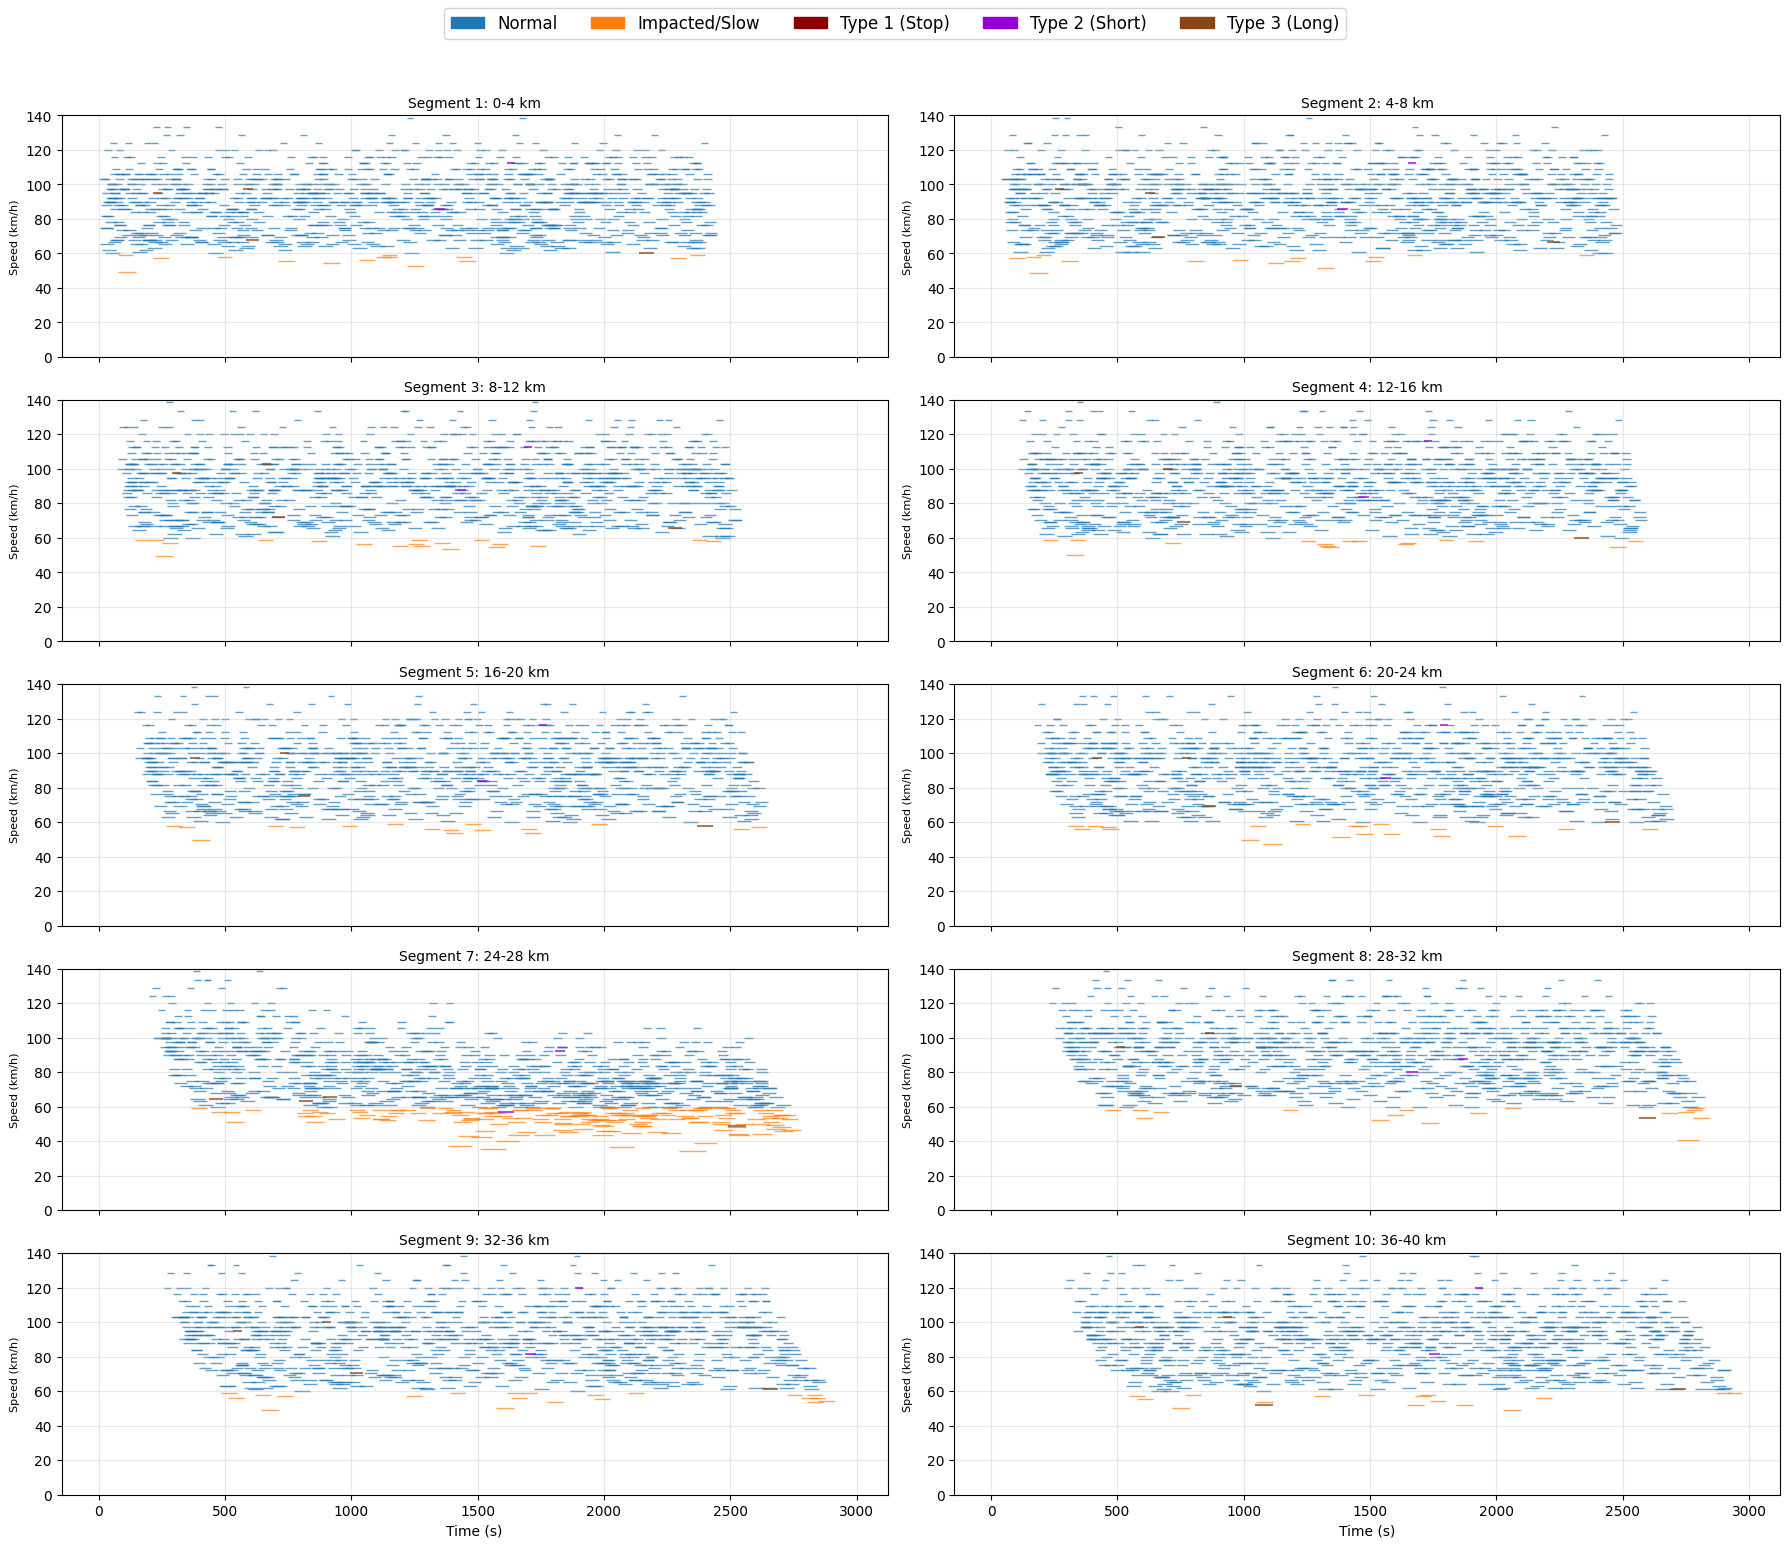

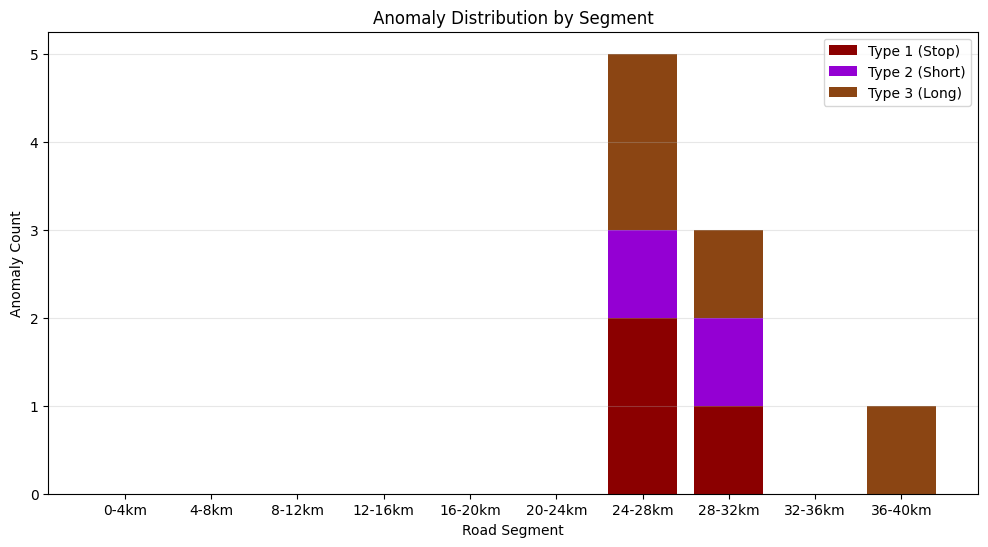


ID     | Type   | Trigger Time | Loc (km)   | State
----------------------------------------------------------------------
127    | 3      | 466.0        | 6.77       | Active
290    | 1      | 794.0        | 6.12       | Active
307    | 3      | 815.0        | 6.63       | Active
315    | 3      | 1063.0       | 9.37       | Active
563    | 1      | 1393.0       | 6.48       | Active
663    | 2      | 1601.0       | 6.38       | Active
802    | 2      | 1851.0       | 7.17       | Active
1067   | 3      | 2592.0       | 7.52       | Active
1167   | 1      | 2655.0       | 7.98       | Active


In [8]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import os

# --- 配置参数 (Configuration) ---
ROAD_LENGTH_KM = 10
SEGMENT_LENGTH_KM = 1
NUM_SEGMENTS = int(ROAD_LENGTH_KM / SEGMENT_LENGTH_KM)  # 10个区间
NUM_LANES = 4
TOTAL_VEHICLES_TARGET = 1200
SIMULATION_DT = 1.0  # 模拟步长 1秒

# 动力学参数 (m/s, m/s^2)
ACCEL_NORMAL = 3.0
DECEL_NORMAL = 3.0
DECEL_ANOMALY_TYPE1 = 7.0
DECEL_ANOMALY_TYPE23 = 4.0

# 速度设定 (km/h -> m/s)
def kmh_to_ms(v): return v / 3.6
def ms_to_kmh(v): return v * 3.6

SPEED_HIGH = (110, 120)
SPEED_NORMAL = (90, 90)
SPEED_LOW = (80, 80)

# 异常参数
ANOMALY_RATIO = 0.01        # 1% 的车是潜在异常车
GLOBAL_ANOMALY_START = 200  # 全局仿真时间必须 > 200s
VEHICLE_SAFE_RUN_TIME = 200 # 车辆自身必须正常跑满 200s
ANOMALY_IMPACT_DIST = 250   # 米 (后方影响范围)
TYPE1_BLOCK_DIST = 100      # 米 (前后封锁范围)
IMPACT_DISCOVER_DIST = 150  # 米 (发现异常车的距离)
LANE_CHANGE_DELAY = 2.0     # 秒 (换道延迟触发时间)
SLOWDOWN_RATIO = 0.7        # 减速叠加比例

# 颜色定义
COLOR_NORMAL = '#1f77b4'  # Blue
COLOR_IMPACTED = '#ff7f0e' # Orange
COLOR_TYPE1 = '#8b0000'    # Dark Red (完全静止)
COLOR_TYPE2 = '#9400d3'    # Purple (短暂)
COLOR_TYPE3 = '#8b4513'    # Saddle Brown (长时)

# --- 车辆类 (Vehicle Class) ---
class Vehicle:
    def __init__(self, v_id, entry_time, lane):
        self.id = v_id
        self.lane = lane # 0, 1, 2, 3
        self.pos = 0.0   # meters
        
        # 速度初始化 - 正态分布
        r = random.random()
        if r < 0.15: # 高速 (均值115, 标准差8)
            base_speed = random.gauss(115, 8)
        elif r < 0.75: # 正常 (均值95, 标准差8)
            base_speed = random.gauss(95, 8)
        else: # 低速 (均值70, 标准差5)
            base_speed = random.gauss(70, 5)
        
        # 限制在合理范围内
        base_speed = max(50, min(140, base_speed))
        
        # 初始速度波动 +/- 10%
        self.desired_speed = kmh_to_ms(base_speed * random.uniform(0.9, 1.1))
        self.speed = self.desired_speed
        
        # 速度稳定计时器（10秒内保持速度不变）
        self.speed_stable_timer = 10.0
        
        # 异常属性
        self.is_potential_anomaly = (random.random() < ANOMALY_RATIO)
        self.anomaly_type = 0 # 0:None, 1:Stop, 2:Short, 3:Long
        self.anomaly_state = 'normal' # normal, active, cooling
        self.anomaly_timer = 0
        self.cooldown_timer = 0
        self.color = COLOR_NORMAL
        
        # 记录数据
        self.logs = {} 
        self.current_segment = 0
        self.entry_time = entry_time
        self.finished = False

        self.lane_change_cooldown = 0
        self.discover_time = None  # 发现异常车的时间戳
        self.impact_count = 0      # 周围异常源数量（用于减速叠加）
        self.lane_change_pending = False  # 是否在等待换道延迟
        self.lane_change_wait_start = 0   # 换道等待开始时间

    def trigger_anomaly(self, current_time, segment_idx):
        """尝试触发异常状态机 (修复后的逻辑)"""
        # 1. 基础资格检查
        if not self.is_potential_anomaly: return None
        if self.anomaly_state == 'active': return None
        
        # 2. 冷却期检查
        if self.anomaly_state == 'cooling':
            self.cooldown_timer -= 1
            if self.cooldown_timer <= 0:
                self.anomaly_state = 'normal' # 冷却结束，允许复发
            else:
                return None # 还在冷却中

        # 3. 时间门槛检查 (核心修复点)
        # 全局时间必须 > 200s
        if current_time < GLOBAL_ANOMALY_START: return None
        # 车辆自身必须正常运行了 200s (避免刚进场就坏)
        if (current_time - self.entry_time) < VEHICLE_SAFE_RUN_TIME: return None

        # 4. 触发判定
        trigger = False
        
        # 情况A: 第一次触发
        if self.anomaly_type == 0:
            # 这里的概率控制着"满足条件后多久触发"。
            # 0.005/s 意味着平均 200秒内会触发。防止所有满足条件的车同一秒爆炸。
            if random.random() < 0.005: 
                trigger = True
                # 随机决定异常类型
                r = random.random()
                if r < 0.33: self.anomaly_type = 1
                elif r < 0.66: self.anomaly_type = 2
                else: self.anomaly_type = 3
                
        # 情况B: 复发 (Type 2/3)
        elif self.anomaly_type in [2, 3]: 
            # 冷却结束后，每秒 30% 概率复发
            if random.random() < 0.3: 
                trigger = True
        
        # 5. 执行触发
        if trigger:
            self.anomaly_state = 'active'
            
            if self.anomaly_type == 1:
                self.target_speed_override = 0
                self.color = COLOR_TYPE1
                self.anomaly_timer = 999999 # 永久
            elif self.anomaly_type == 2:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 10 # 持续10s
                self.color = COLOR_TYPE2
            elif self.anomaly_type == 3:
                self.target_speed_override = kmh_to_ms(random.uniform(0, 40))
                self.anomaly_timer = 20 # 持续20s
                self.color = COLOR_TYPE3
            
            return {
                'id': self.id,
                'type': self.anomaly_type,
                'time': current_time,
                'pos_km': self.pos / 1000.0,
                'segment': segment_idx,
                'min_speed': ms_to_kmh(self.target_speed_override)
            }
        return None

    def update(self, dt, vehicles_nearby, blocked_lanes, current_time):
        """更新车辆物理状态"""
        if self.finished: return

        # --- 状态机倒计时 ---
        target_v = self.desired_speed
        max_decel = DECEL_NORMAL
        
        if self.anomaly_state == 'active':
            target_v = self.target_speed_override
            if self.anomaly_type == 1: max_decel = DECEL_ANOMALY_TYPE1
            else: max_decel = DECEL_ANOMALY_TYPE23
            
            self.anomaly_timer -= dt
            # 异常结束恢复
            if self.anomaly_timer <= 0 and self.anomaly_type != 1:
                self.anomaly_state = 'cooling'
                self.cooldown_timer = 1000 # 冷却1000s
                self.color = COLOR_NORMAL
        
        # --- 交互逻辑 (前车判定) ---
        leader = None
        min_dist = 99999
        
        for other in vehicles_nearby:
            if other.lane == self.lane and other.pos > self.pos:
                dist = other.pos - self.pos
                if dist < min_dist:
                    min_dist = dist
                    leader = other
        
        # --- 异常影响 & Type 1 封锁 ---
        impacted_by_anomaly = False
        
        # 统计周围±150m内异常源数量（用于减速叠加）
        anomaly_sources_nearby = 0
        for other in vehicles_nearby:
            if other != self and other.anomaly_state == 'active':
                dist = abs(other.pos - self.pos)
                if dist < IMPACT_DISCOVER_DIST:  # ±150m范围内
                    anomaly_sources_nearby += 1
        
        # 应用85%减速叠加
        if anomaly_sources_nearby > 0:
            slowdown_factor = SLOWDOWN_RATIO ** anomaly_sources_nearby
            target_v = target_v * slowdown_factor
            impacted_by_anomaly = True
        
        if leader:
            # Type 1 封锁
            if leader.anomaly_type == 1 and min_dist < TYPE1_BLOCK_DIST + 50:
                target_v = 0
                max_decel = DECEL_ANOMALY_TYPE1
            # Type 2/3 影响
            elif leader.anomaly_state == 'active' and min_dist < ANOMALY_IMPACT_DIST:
                target_v = min(target_v, leader.speed * 0.8)
                impacted_by_anomaly = True
        
        # --- 换道逻辑 (2s延迟触发机制) ---
        self.lane_change_cooldown -= dt
        
        # 检查是否需要进入换道等待状态（同车道发现异常车）
        want_change = False
        if leader:
            safe_following_dist = self.speed * 2 + 15
            # 前方有Type1 或 距离过近触发换道
            if (min_dist < safe_following_dist) or (leader.anomaly_type == 1 and min_dist < 200):
                want_change = True
        
        # 同车道处理：发现异常后进入2s倒计时
        if leader and leader.anomaly_state == 'active' and leader.lane == self.lane and min_dist < IMPACT_DISCOVER_DIST:
            if not self.lane_change_pending:
                self.lane_change_pending = True
                self.lane_change_wait_start = current_time
        
        # 检查2s延迟是否结束
        if self.lane_change_pending:
            if current_time - self.lane_change_wait_start >= LANE_CHANGE_DELAY:
                self.lane_change_pending = False
                # 延迟结束后执行换道判断
                if want_change and self.lane_change_cooldown <= 0:
                    self._execute_lane_change(vehicles_nearby, blocked_lanes)
        elif want_change and self.lane_change_cooldown <= 0:
            # 非同车道异常的换道直接执行
            self._execute_lane_change(vehicles_nearby, blocked_lanes)

        # --- 颜色更新 ---
        if self.anomaly_state != 'active':
            if impacted_by_anomaly or (leader and min_dist < 40 and self.speed < 20):
                self.color = COLOR_IMPACTED
            else:
                self.color = COLOR_NORMAL

        # --- 车速波动逻辑（10秒稳定期后微调） ---
        if self.anomaly_state == 'normal' and self.speed_stable_timer > 0:
            self.speed_stable_timer -= dt
        elif self.anomaly_state == 'normal' and self.speed_stable_timer <= 0:
            # 10秒后有机会微调 ±5%
            if random.random() < 0.1:  # 每秒10%概率触发微调
                adjustment = random.uniform(0.95, 1.05)
                self.speed = self.speed * adjustment
                # 重置计时器
                self.speed_stable_timer = 10.0

        # --- 物理积分 ---
        if self.speed < target_v:
            self.speed += ACCEL_NORMAL * dt
        elif self.speed > target_v:
            self.speed -= max_decel * dt
        if self.speed < 0: self.speed = 0
        
        self.pos += self.speed * dt
        
        # --- 数据记录 ---
        # 注意：这里不应该更新记录，应该在 record_time 中统一处理
        # seg_idx 的计算移到 record_time 调用之前
            
    def _execute_lane_change(self, vehicles_nearby, blocked_lanes):
        """执行换道操作"""
        options = []
        if self.lane > 0: options.append(self.lane - 1)
        if self.lane < NUM_LANES - 1: options.append(self.lane + 1)
        
        random.shuffle(options)
        for target_lane in options:
            safe = True
            # 检查Type 1 封锁
            if target_lane in blocked_lanes:
                for block_pos in blocked_lanes[target_lane]:
                    if abs(block_pos - self.pos) < TYPE1_BLOCK_DIST:
                        safe = False; break
            if not safe: continue

            # 检查目标车道空隙
            for other in vehicles_nearby:
                if other.lane == target_lane:
                    if abs(other.pos - self.pos) < 35: # 间距
                        safe = False; break
            
            if safe:
                self.lane = target_lane
                self.lane_change_cooldown = 5.0
                break
    
    def record_time(self, time_now, seg_idx):
        """记录车辆在各区间的时间"""
        if seg_idx >= NUM_SEGMENTS: 
            self.finished = True
            # 离开最后一个区间时，更新最后区间的 out 时间
            if self.current_segment < NUM_SEGMENTS and self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            return
        
        # 如果进入了新区间
        if seg_idx != self.current_segment:
            # 更新旧区间的离开时间
            if self.current_segment in self.logs:
                self.logs[self.current_segment]['out'] = time_now
            
            # 记录新区间的进入时间
            self.current_segment = seg_idx
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
        else:
            # 在当前区间内，持续更新 out 时间
            if seg_idx not in self.logs:
                self.logs[seg_idx] = {'in': time_now, 'out': time_now}
            else:
                self.logs[seg_idx]['out'] = time_now

# --- 仿真主程序 ---
class TrafficSimulation:
    def __init__(self):
        self.vehicles = []
        self.finished_vehicles = []
        self.current_time = 0
        self.vehicle_id_counter = 0
        self.anomaly_logs = []
        self.spawn_schedule = []
        self.plan_spawns()
        
    def plan_spawns(self):
        """生成随机投放计划：每10s随机2-8辆"""
        total_generated = 0
        t_cycle = 0
        while total_generated < TOTAL_VEHICLES_TARGET:
            n = random.randint(2, 8) # 随机数量
            if total_generated + n > TOTAL_VEHICLES_TARGET:
                n = TOTAL_VEHICLES_TARGET - total_generated
            
            # 在这10s内随机时间点
            timestamps = sorted([t_cycle + random.uniform(0, 10) for _ in range(n)])
            for ts in timestamps:
                self.spawn_schedule.append(ts)
            
            total_generated += n
            t_cycle += 10
            
    def run(self):
        print("仿真初始化... 目标车辆: 1200")
        spawn_idx = 0
        
        while len(self.vehicles) > 0 or spawn_idx < len(self.spawn_schedule):
            # 1. 车辆投放 (带空间冲突检测)
            while spawn_idx < len(self.spawn_schedule) and self.spawn_schedule[spawn_idx] <= self.current_time:
                lane_choice = list(range(NUM_LANES))
                random.shuffle(lane_choice)
                placed = False
                
                for lane in lane_choice:
                    clear = True
                    # 检查入口50米是否有车
                    for v in self.vehicles:
                        if v.lane == lane and v.pos < 50:
                            clear = False; break
                    if clear:
                        new_v = Vehicle(self.vehicle_id_counter, self.current_time, lane)
                        self.vehicles.append(new_v)
                        self.vehicle_id_counter += 1
                        placed = True
                        break
                
                if placed:
                    spawn_idx += 1
                else:
                    # 如果堵死，推迟到下一秒
                    self.spawn_schedule[spawn_idx] += 1.0
                    break 

            # 2. 空间索引
            active_vehicles = [v for v in self.vehicles if not v.finished]
            active_vehicles.sort(key=lambda x: x.pos)
            
            blocked_lanes = defaultdict(list)
            for v in active_vehicles:
                if v.anomaly_type == 1 and v.anomaly_state == 'active':
                    blocked_lanes[v.lane].append(v.pos)

            # 3. 更新
            for v in active_vehicles:
                seg = int(v.pos / (SEGMENT_LENGTH_KM * 1000))
                v.record_time(self.current_time, seg)
                
                # 异常检测
                log = v.trigger_anomaly(self.current_time, seg)
                if log:
                    self.anomaly_logs.append(log)
                    print(f"[ALERT] ID:{log['id']:<4} Type:{log['type']} Time:{log['time']:.0f}s Loc:{log['pos_km']:.2f}km")

                v.update(SIMULATION_DT, active_vehicles, blocked_lanes, self.current_time)

            # 4. 清理
            completed = [v for v in self.vehicles if v.finished]
            self.finished_vehicles.extend(completed)
            self.vehicles = [v for v in self.vehicles if not v.finished]
            
            self.current_time += SIMULATION_DT
            
            if int(self.current_time) % 200 == 0:
                print(f"Time: {int(self.current_time)}s | Active: {len(self.vehicles)} | Done: {len(self.finished_vehicles)}")
                # 超时保护 (比如3小时)
                if self.current_time > 10800: break
            
            # 每1000s保存一次快照
            if int(self.current_time) % 1000 == 0 and int(self.current_time) > 0:
                save_snapshot(self.finished_vehicles, self.anomaly_logs, self.current_time)

        print("仿真完成。")

# --- 可视化模块 ---
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_snapshot(finished_vehicles, anomaly_logs, current_time):
    """保存中间快照图"""
    if len(finished_vehicles) == 0:
        return
    
    print(f"正在保存 {int(current_time)}s 时刻快照...")
    
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                if t_out - t_in < 0.1: 
                    continue
                
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    
    # 保存PNG
    filename = os.path.join(OUTPUT_DIR, f"traffic_snapshot_{int(current_time)}s.png")
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    print(f"已保存: {filename}")
    plt.close()

def plot_results(finished_vehicles, anomaly_logs):
    print("正在渲染图表 (可能需要几秒钟)...")
    print(f"完成车辆数: {len(finished_vehicles)}")
    print(f"异常事件数: {len(anomaly_logs)}")
    
    # 统计有记录的车辆数
    vehicles_with_logs = sum(1 for v in finished_vehicles if len(v.logs) > 0)
    print(f"有区间记录的车辆数: {vehicles_with_logs}")
    
    # 统计每个区间的记录数
    segment_counts = [0] * NUM_SEGMENTS
    for v in finished_vehicles:
        for seg_idx in v.logs:
            if seg_idx < NUM_SEGMENTS:
                segment_counts[seg_idx] += 1
    print(f"各区间记录数: {segment_counts}")
    
    # 1. 速度画像 (10个子图)
    fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
    axes = axes.flatten()
    
    for seg_idx in range(NUM_SEGMENTS):
        ax = axes[seg_idx]
        ax.set_title(f"Segment {seg_idx+1}: {seg_idx*4}-{(seg_idx+1)*4} km", fontsize=10)
        ax.set_ylabel("Speed (km/h)", fontsize=8)
        ax.set_ylim(0, 140)
        ax.grid(True, alpha=0.3)
        
        for v in finished_vehicles:
            if seg_idx in v.logs:
                info = v.logs[seg_idx]
                t_in, t_out = info['in'], info['out']
                
                # 确保时间差有效（至少0.1秒）
                if t_out - t_in < 0.1: 
                    continue
                
                # 计算平均速度 (km/h)
                distance_m = SEGMENT_LENGTH_KM * 1000
                time_s = t_out - t_in
                avg_speed_kmh = (distance_m / time_s) * 3.6
                
                # 限制速度范围（避免异常值）
                if avg_speed_kmh > 200 or avg_speed_kmh < 0:
                    continue
                
                # 颜色逻辑
                c = COLOR_NORMAL
                z = 1
                w = 1.0
                if v.anomaly_type == 1: c, z, w = COLOR_TYPE1, 10, 2.0
                elif v.anomaly_type == 2: c, z, w = COLOR_TYPE2, 8, 1.5
                elif v.anomaly_type == 3: c, z, w = COLOR_TYPE3, 8, 1.5
                elif avg_speed_kmh < 60: c, z = COLOR_IMPACTED, 5 # 拥堵
                
                ax.hlines(y=avg_speed_kmh, xmin=t_in, xmax=t_out, 
                          colors=c, alpha=0.7, linewidth=w, zorder=z)

    axes[-1].set_xlabel("Time (s)")
    axes[-2].set_xlabel("Time (s)")
    
    # 图例
    patches = [
        mpatches.Patch(color=COLOR_NORMAL, label='Normal'),
        mpatches.Patch(color=COLOR_IMPACTED, label='Impacted/Slow'),
        mpatches.Patch(color=COLOR_TYPE1, label='Type 1 (Stop)'),
        mpatches.Patch(color=COLOR_TYPE2, label='Type 2 (Short)'),
        mpatches.Patch(color=COLOR_TYPE3, label='Type 3 (Long)'),
    ]
    fig.legend(handles=patches, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

    # 2. 异常统计堆叠柱状图
    plt.figure(figsize=(12, 6))
    counts = {seg: {1:0, 2:0, 3:0} for seg in range(NUM_SEGMENTS)}
    for log in anomaly_logs:
        seg = log['segment']
        if seg < NUM_SEGMENTS:
            counts[seg][log['type']] += 1
            
    x_labels = [f"{i*4}-{(i+1)*4}km" for i in range(NUM_SEGMENTS)]
    y1 = [counts[i][1] for i in range(NUM_SEGMENTS)]
    y2 = [counts[i][2] for i in range(NUM_SEGMENTS)]
    y3 = [counts[i][3] for i in range(NUM_SEGMENTS)]
    
    x = range(len(x_labels))
    plt.bar(x, y1, color=COLOR_TYPE1, label='Type 1 (Stop)')
    plt.bar(x, y2, bottom=y1, color=COLOR_TYPE2, label='Type 2 (Short)')
    plt.bar(x, y3, bottom=[sum(x) for x in zip(y1, y2)], color=COLOR_TYPE3, label='Type 3 (Long)')
    
    plt.xlabel('Road Segment')
    plt.ylabel('Anomaly Count')
    plt.title('Anomaly Distribution by Segment')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 3. 终端打印
    print("\n" + "="*70)
    print(f"{'ID':<6} | {'Type':<6} | {'Trigger Time':<12} | {'Loc (km)':<10} | {'State'}")
    print("-" * 70)
    for log in anomaly_logs:
        print(f"{log['id']:<6} | {log['type']:<6} | {log['time']:<12.1f} | {log['pos_km']:<10.2f} | Active")
    print("="*70)

if __name__ == "__main__":
    sim = TrafficSimulation()
    sim.run()
    plot_results(sim.finished_vehicles, sim.anomaly_logs)